# Importing & Cleaning Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pandas.tseries.offsets import DateOffset

In [2]:
df = pd.read_csv('Historical Product Demand.csv')

In [3]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [4]:
print('This dataframe contains {} rows and {} columns'.format(df.shape[0], df.shape[1]))

This dataframe contains 1048575 rows and 5 columns


In [5]:
# Create a Descriptive Dataframe
kolom_desc = ['Feature Name', 'Feature Type', 'Null Count', 'Null Percentage', 'Unique Data', 'Unique Data Sample']
list_desc = []
for i in df.columns:
    list_desc.append([i,
                      df[i].dtype,
                      df[i].isna().sum(),
                      round((df[i].isna().sum()/len(df[i]))*100,2),
                      df[i].nunique(),
                      list(df[i].drop_duplicates().sample(2, replace = True).values)
                     ])
df_desc = pd.DataFrame(columns = kolom_desc, data = list_desc)
df_desc

,Feature Name,Feature Type,Null Count,Null Percentage,Unique Data,Unique Data Sample
0,Product_Code,object,0,0.00,2160,"[Product_1034, Product_0145]"
1,Warehouse,object,0,0.00,4,"[Whse_C, Whse_S]"
2,Product_Category,object,0,0.00,33,"[Category_018, Category_018]"
3,Date,object,11239,1.07,1729,"[2014/7/17, 2012/12/28]"
4,Order_Demand,object,0,0.00,3828,"[522000 , 2364 ]"


It seems that the dataframe contains 1% of null values. I'm going to drop them as it is only 1% of the data.

In [6]:
df = df.dropna()

In [7]:
df.isna().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [10]:
df.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1037336,1037336,1037336,1037336,1037336
unique,2160,4,33,1729,3749
top,Product_1359,Whse_J,Category_019,2013-09-27 00:00:00,1000
freq,16936,764447,470266,2075,112263
first,NaN,NaN,NaN,2011-01-08 00:00:00,NaN
last,NaN,NaN,NaN,2017-01-09 00:00:00,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1037336 non-null  object        
 1   Warehouse         1037336 non-null  object        
 2   Product_Category  1037336 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1037336 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 47.5+ MB


It seems that Order_Demand, the target variable that I am trying to forecast still not in Integer type. Let's do some exploration.

In [12]:
df = df.sort_values(by = 'Date')
df.head(20)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2
72252,Product_1724,Whse_A,Category_003,2011-05-31,108
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250
17249,Product_0608,Whse_C,Category_001,2011-09-27,5
17250,Product_1933,Whse_C,Category_001,2011-09-27,23
74615,Product_0875,Whse_C,Category_023,2011-09-30,5450
131426,Product_0125,Whse_S,Category_011,2011-10-20,(2)
131429,Product_0412,Whse_S,Category_007,2011-10-20,(2)


In [13]:
# Dropping the brackets in the Order_Demand feature
df['Order_Demand'] = df['Order_Demand'].str.replace('(', '')
df['Order_Demand'] = df['Order_Demand'].str.replace(')', '')
df['Order_Demand'] = df['Order_Demand'].astype('int')

In [14]:
df.head(20)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2
72252,Product_1724,Whse_A,Category_003,2011-05-31,108
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250
17249,Product_0608,Whse_C,Category_001,2011-09-27,5
17250,Product_1933,Whse_C,Category_001,2011-09-27,23
74615,Product_0875,Whse_C,Category_023,2011-09-30,5450
131426,Product_0125,Whse_S,Category_011,2011-10-20,2
131429,Product_0412,Whse_S,Category_007,2011-10-20,2


# EDA

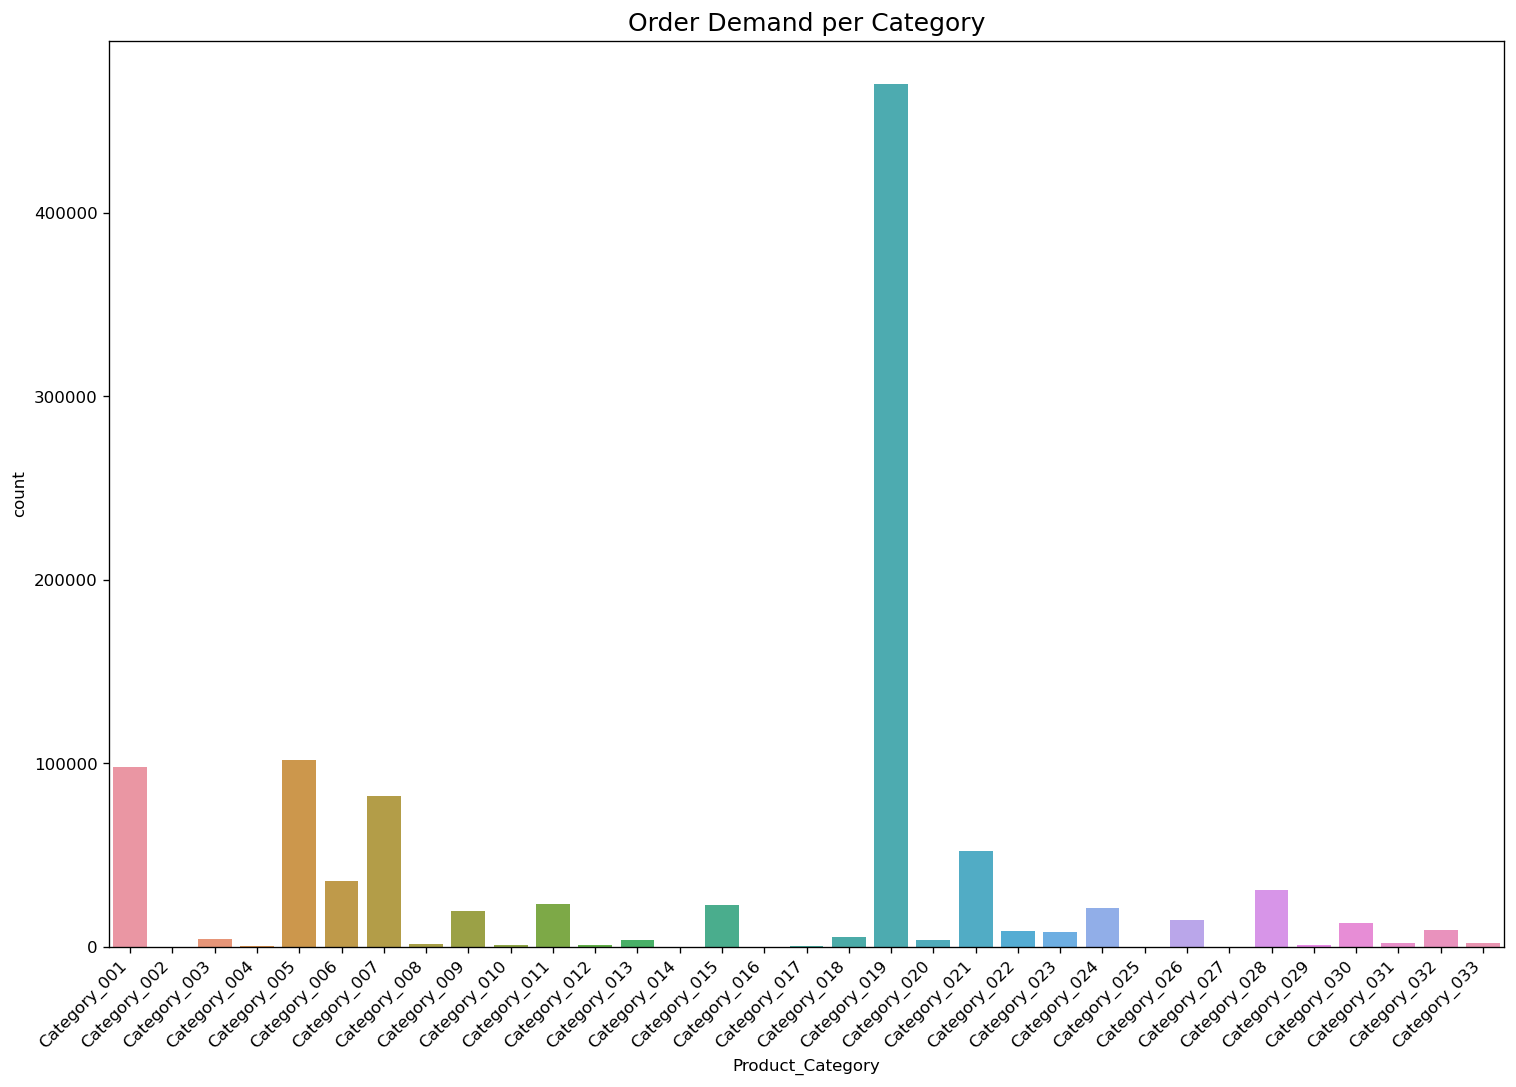

In [45]:
plt.figure(figsize = (15,10))
prod_plot = sns.countplot(df['Product_Category'].sort_values(ascending = True))
prod_plot.set_xticklabels(prod_plot.get_xticklabels(), 
                                        horizontalalignment='right', rotation=45)
plt.title('Order Demand per Category', fontsize = 15)
plt.show()

> It seems that Category_019 is the best selling product.

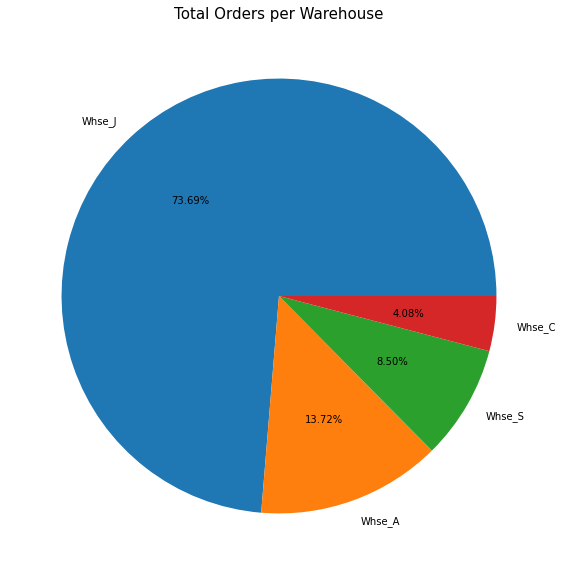

In [16]:
wh = list(df.groupby(by = ['Warehouse'])['Order_Demand'].count().sort_values(ascending = False))
labels_wh = list(df['Warehouse'].value_counts().index)

plt.figure(figsize=(15,10))

plt.pie(wh, labels = labels_wh, autopct='%1.2f%%')
plt.title('Total Orders per Warehouse', fontsize = 15)
plt.show()


> It seems that Warehouse J is the busiest in receiving orders.

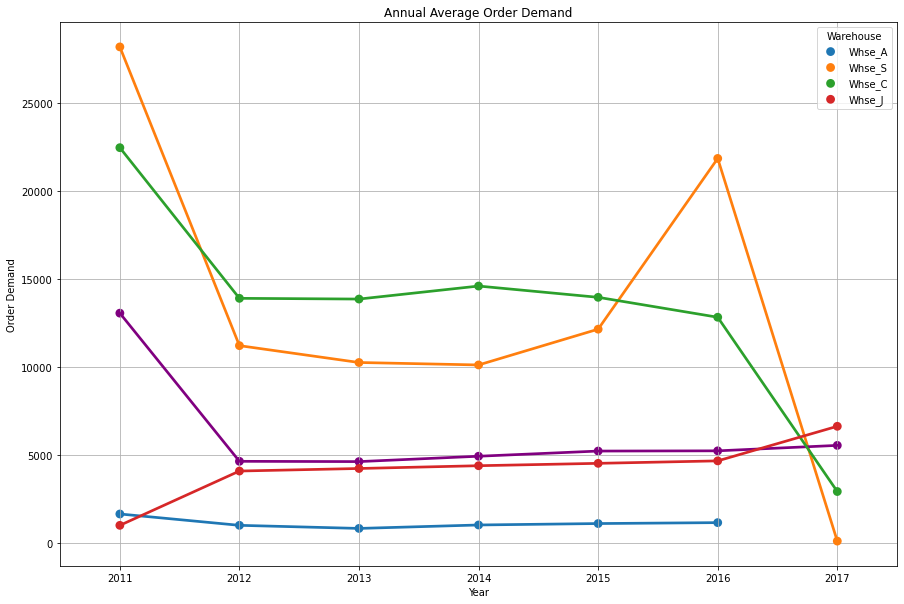

In [17]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

plt.figure(figsize = (15,10))
yearly_order = sns.pointplot(x = 'Year', y = 'Order_Demand', hue = 'Warehouse', data = df, ci = 0)
yearly_order = sns.pointplot(x = 'Year', y = 'Order_Demand', data = df, ci = 0, color = 'purple')
plt.xlabel('Year')
plt.ylabel('Order Demand')
plt.title('Annual Average Order Demand')
plt.grid()
plt.show()

> It sort of weird that in 2011, the average order demand is really high. The purple line represents the overall order demand.

# Building Model

In [18]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year
44799,Product_0965,Whse_A,Category_006,2011-01-08,2,2011
72252,Product_1724,Whse_A,Category_003,2011-05-31,108,2011
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000,2011
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000,2011
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250,2011


In [19]:
# Creating a new dataframe consisting just for Date and Order_Demand
df_ts = df.groupby('Date')['Order_Demand'].sum().reset_index()
df_ts = df_ts.set_index('Date')

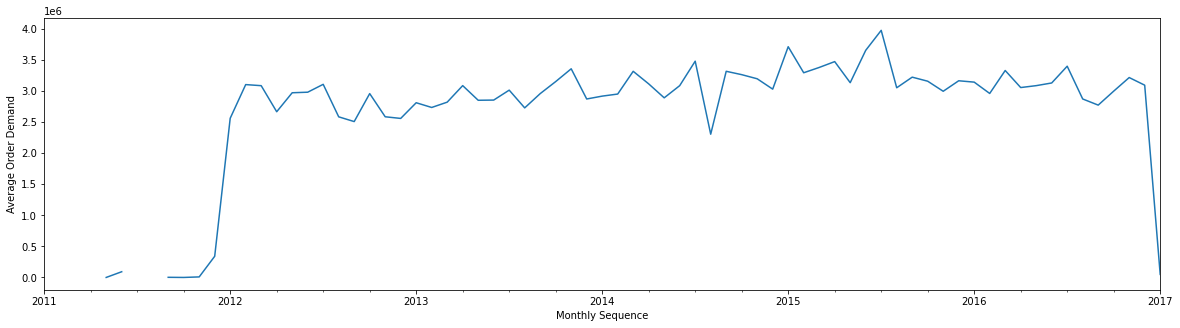

In [20]:
# Resampling the datetime value into monthly frequency
df_ts['Order_Demand'].resample('MS').mean().plot(figsize = (20,5))
plt.xlabel('Monthly Sequence')
plt.ylabel('Average Order Demand')
plt.show()

> From plot above, it seems that it is wise to use only the 2012 to 2016 data because in 2011 there are many missing dates and there is not enough informations in 2017.

In [21]:
# Creating a new data
df_ts = df_ts.reset_index()
df_ts = df_ts[(df_ts['Date'] >= '2012-01-01') & (df_ts['Date'] <= '2016-12-31')]

In [22]:
df_ts = df_ts.set_index('Date')

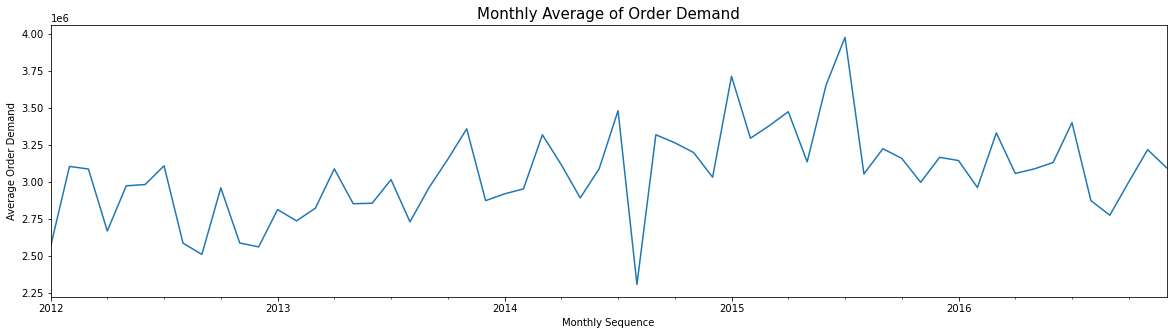

In [23]:
# Do the same thing as above, resampling the datetime data into monthly sequence and showing the average order demand
df_ori = df_ts['Order_Demand'].resample('MS').mean()
df_ori.plot(figsize = (20,5))
plt.xlabel('Monthly Sequence')
plt.ylabel('Average Order Demand')
plt.title('Monthly Average of Order Demand', fontsize = 15)
plt.show()

<b> Check seasonality, trends and residuals and stationarity.

In [24]:
def stationary_test(timeseries):
    result_adf = adfuller(timeseries)
    result_fix = pd.Series(result_adf[0:4], index = ['ADF Test Statistic', 'p-value', 
                                                 'Number of Lags Used', 'Number of Observations Used'])
    for i, j in result_adf[4].items():
        result_fix['Critical Value (%s)'%i] = j
    
    print(result_fix)
    
    if result_adf [1] <= 0.05:
        print('Reject the Null Hypothesis; Data is stationary.')
    else :
        print('Accept the Null Hypothesis; Data is not stationary.')

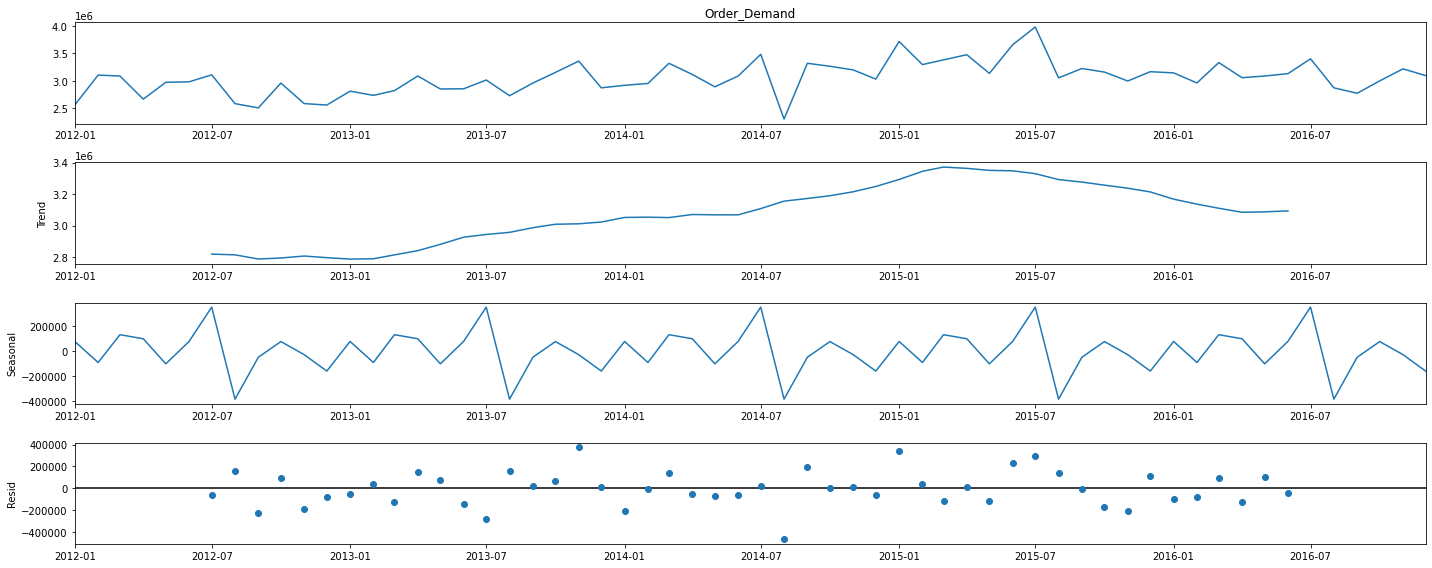

ADF Test Statistic             -1.690040
p-value                         0.436251
Number of Lags Used             3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64
Accept the Null Hypothesis; Data is not stationary.


In [25]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(df_ori, model='additive')
fig = decomposition.plot()
plt.show()
stationary_test(df_ori)

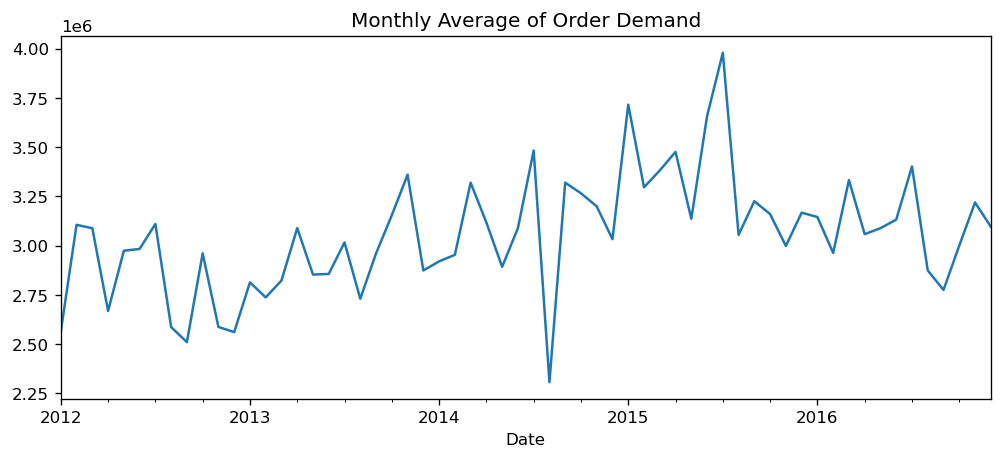

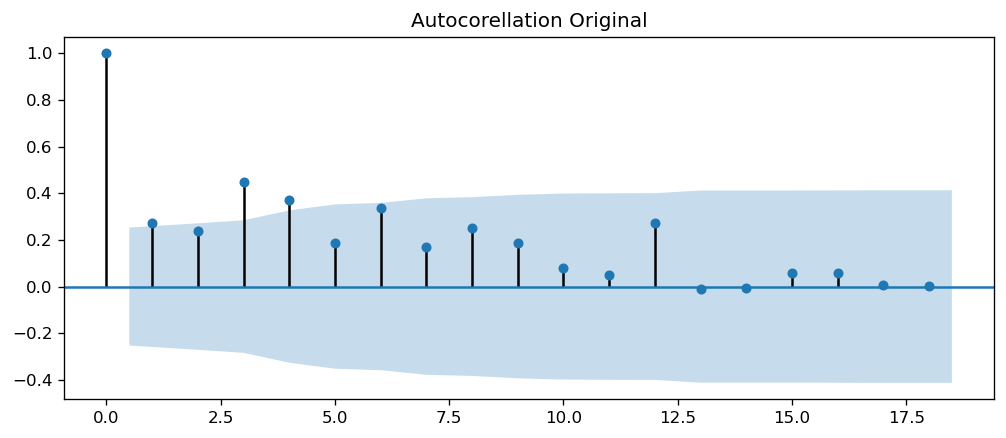

In [26]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})

ori = df_ori.plot()
ori.set_title('Monthly Average of Order Demand')
plot_acf(df_ori, title = 'Autocorellation Original')

plt.show()

The autocorrelation plot from the original data (2012 - 2016) shows the correlation score with each number of the lags, where the blue area is the significance limit. 

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag is 1, autocorrelation itself is too negative, then the series is probably over-differenced. 


Null Hypothesis (H0): Data is not stationary; H1: Data is stationary

For a Time series to be stationary, its ADCF test should have:

- p-value to be low (according to the null hypothesis). For this, let's assume if the p-value is less and equal to 0.05, the data is not stationary.
- The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

From the above ADCF test result, we see that p-value is at 0.436251 and greater than 0.05. Critical values is somewhat close to the ADF Test Statistic. The graph above also shows that the data's statistical properties (mean and variance) changes over time. Because of this, let's assume that the data is not stationary.

<b> Stationary Transformation.

There are a couple of ways to achieve stationarity through data transformation like taking log10,loge, square, square root, cube, cube root, exponential decay, time shift and so on.

For this project, I will try the time shifting method.

In [27]:
df_ts['Monthly Difference'] = df_ts['Order_Demand'] - df_ts['Order_Demand'].shift(30)
df_ts['Yearly Difference'] = df_ts['Order_Demand'] - df_ts['Order_Demand'].shift(365)

<b>1. Monthly Shifted Data

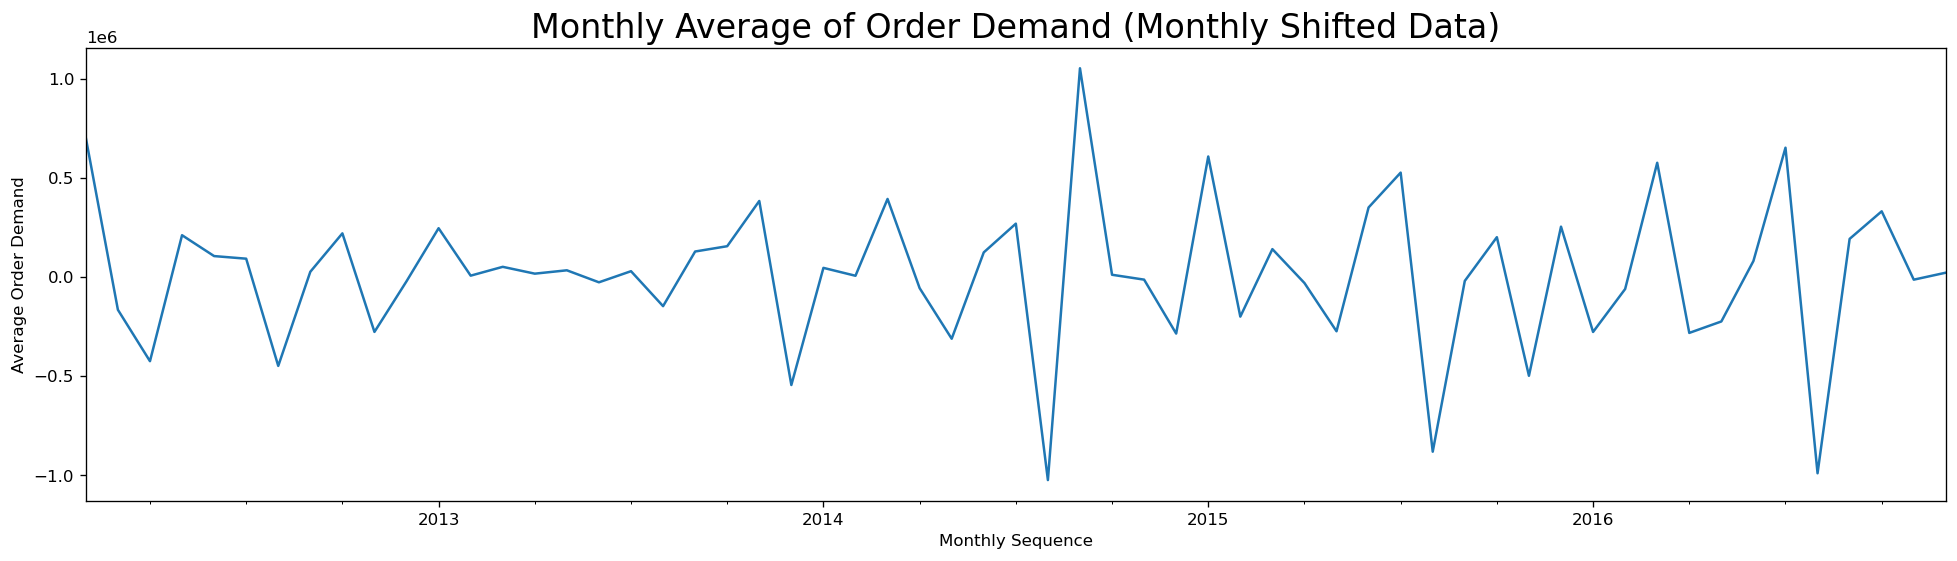

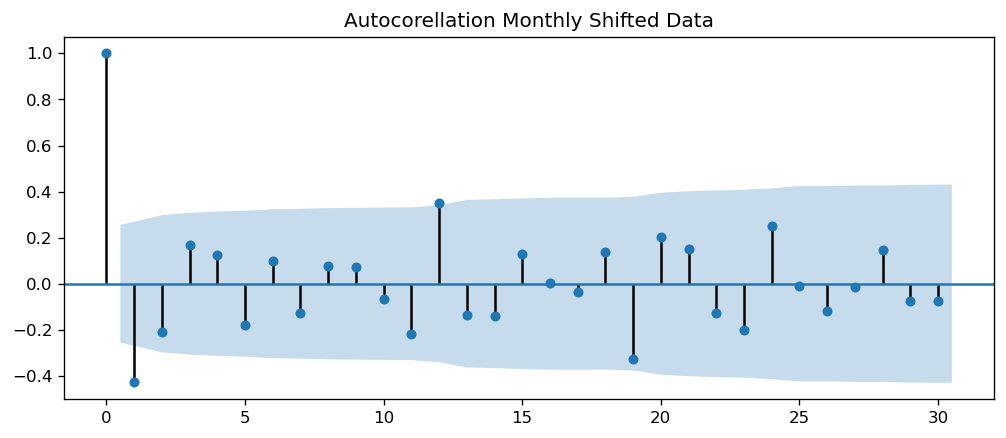

In [28]:
df_shift_monthly = df_ts['Monthly Difference'].resample('MS').mean().dropna()
df_shift_monthly.plot(figsize = (20,5))
plt.xlabel('Monthly Sequence')
plt.ylabel('Average Order Demand')
plt.title('Monthly Average of Order Demand (Monthly Shifted Data)', fontsize = 20)

plot_acf(df_shift_monthly, lags = 30, title = 'Autocorellation Monthly Shifted Data')

plt.show()

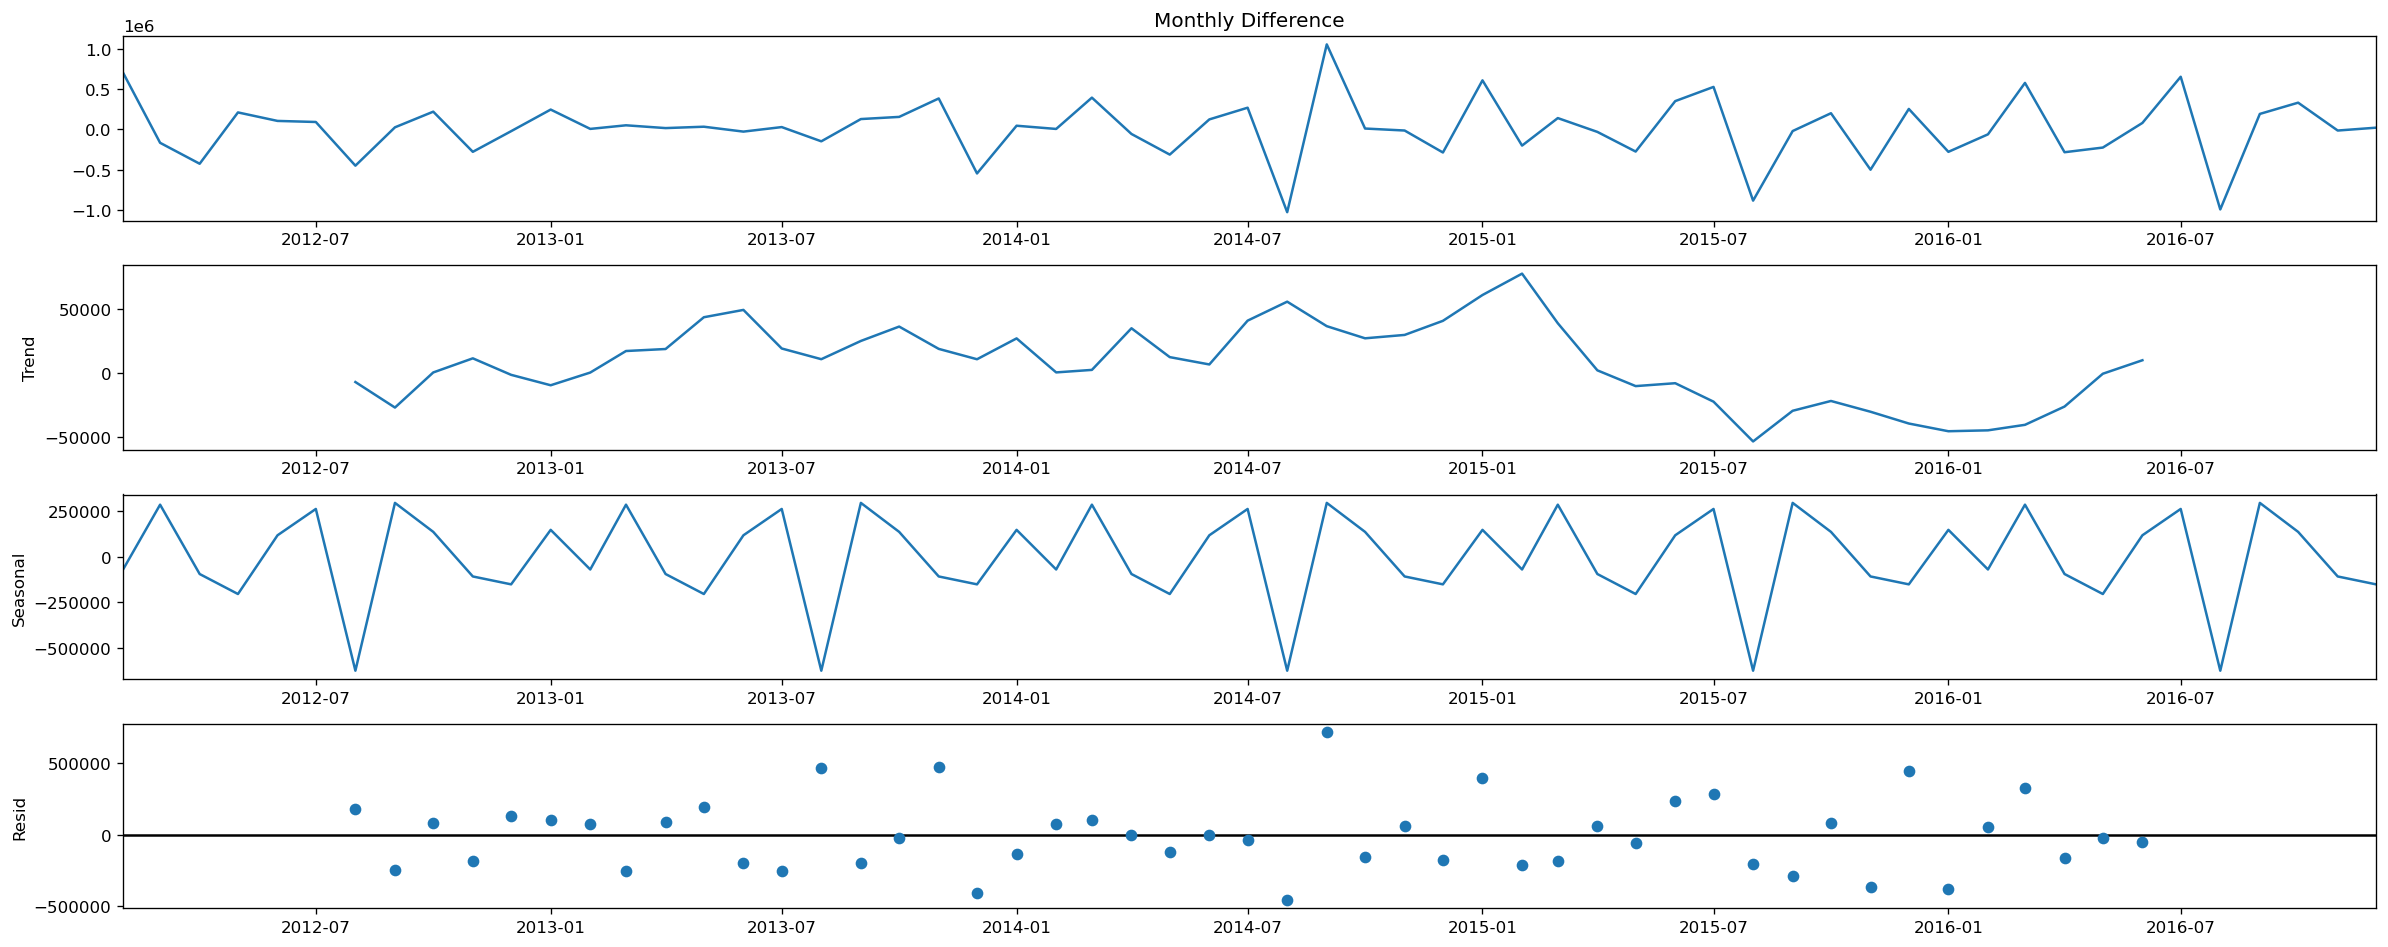

ADF Test Statistic            -8.050937e+00
p-value                        1.742838e-12
Number of Lags Used            2.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64
Reject the Null Hypothesis; Data is stationary.


In [29]:
rcParams['figure.figsize'] = 20, 8
decomposition_1 = sm.tsa.seasonal_decompose(df_shift_monthly, model='additive')
fig = decomposition_1.plot()
plt.show()
stationary_test(df_shift_monthly)

After we shift data to a month, the p-value got much smaller and reject our null hypothesis, so I got a stationary data. But its ADF Test Statistic value is still not that close. So lets try with yearly shifted data.

<b> 2. Yearly Shifted Data

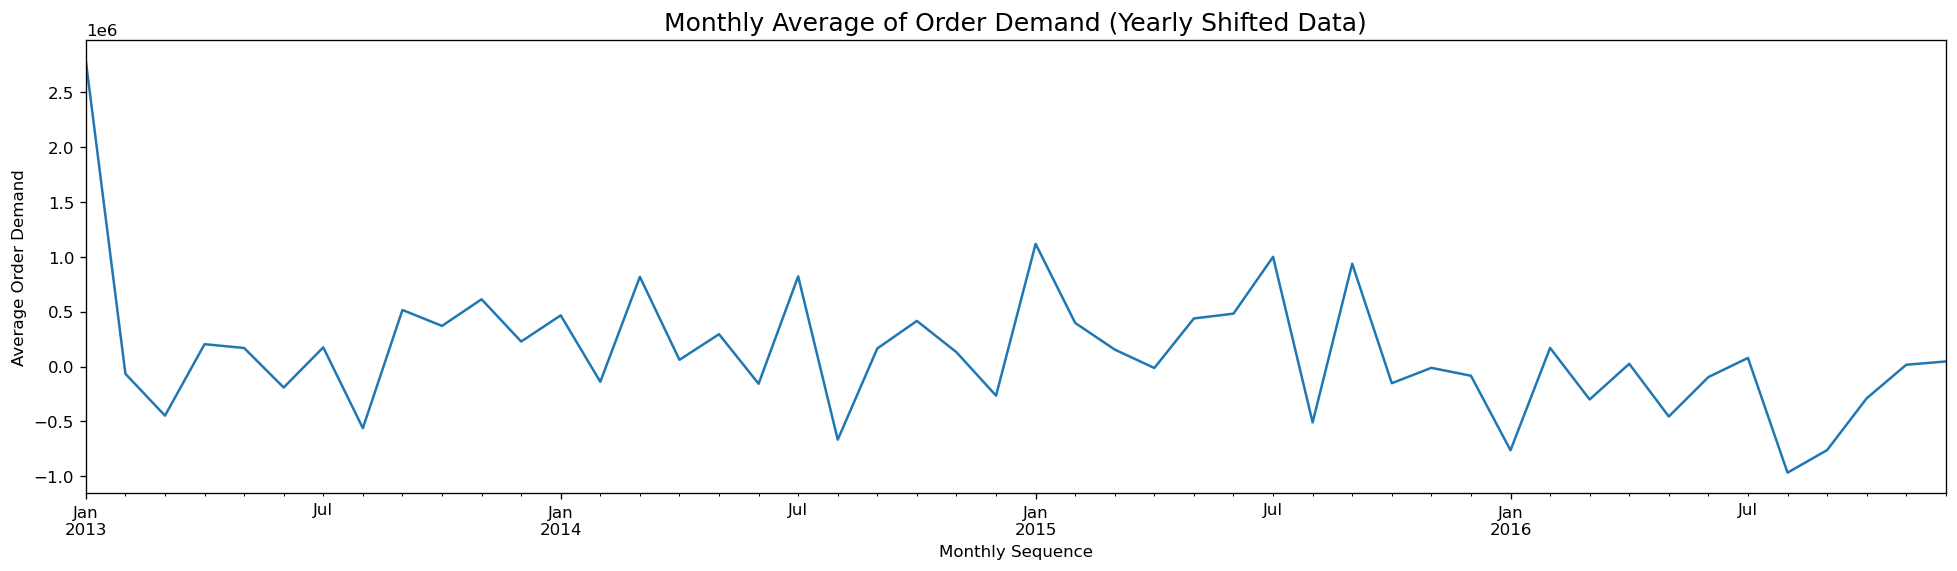

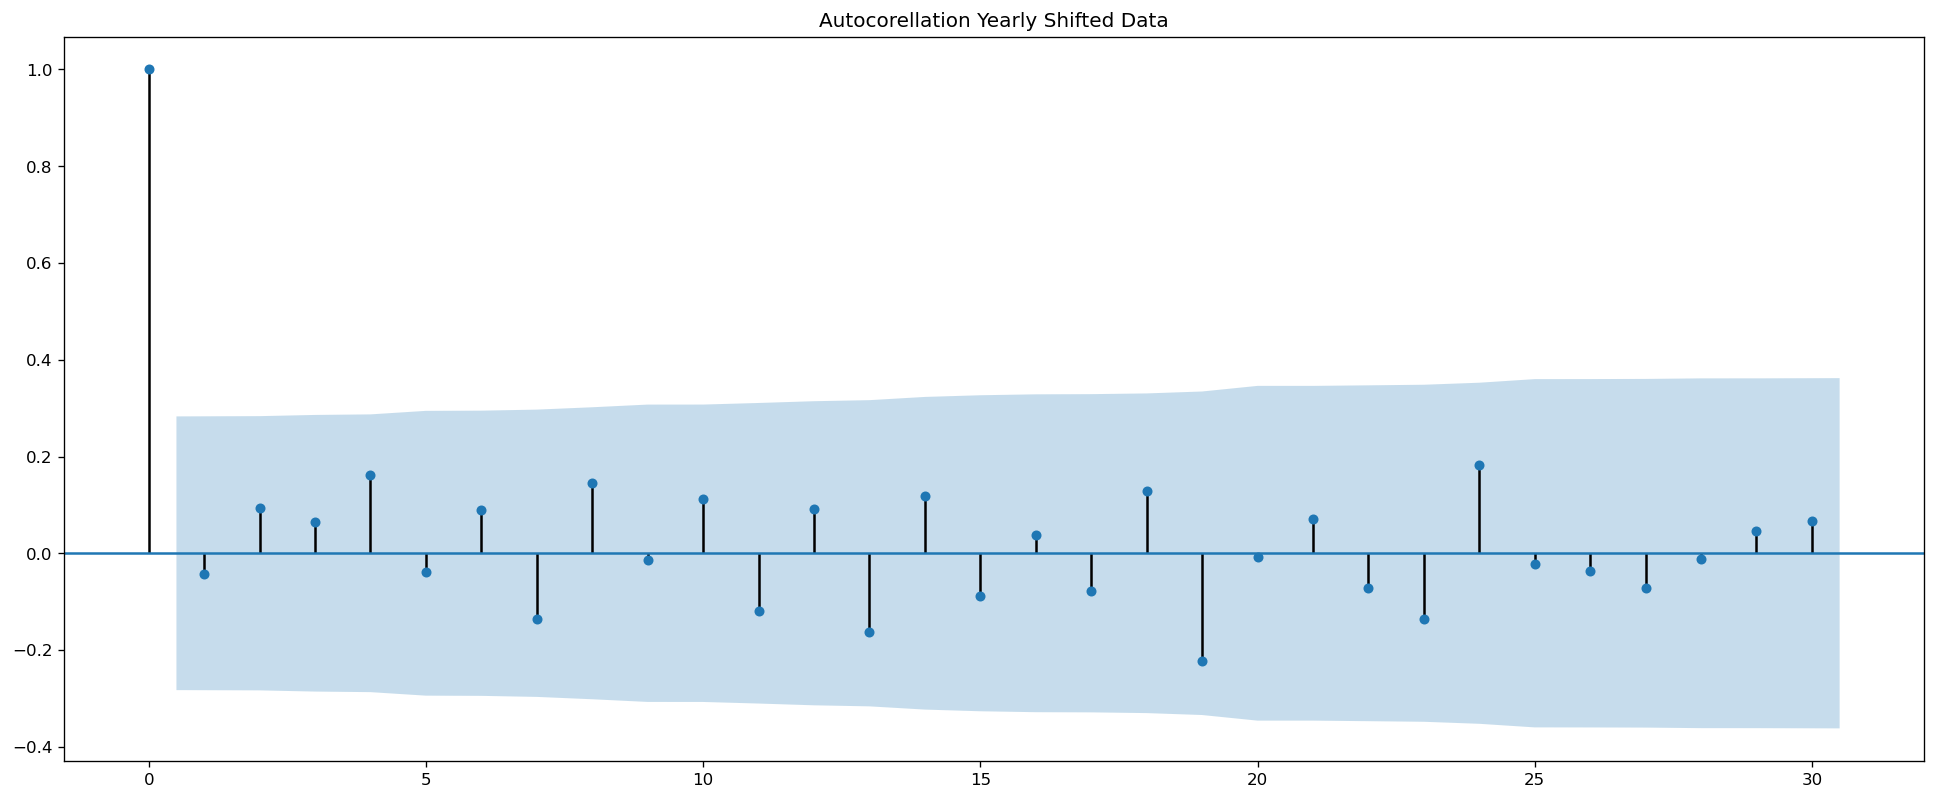

In [30]:
df_shift_yearly = df_ts['Yearly Difference'].resample('MS').mean().dropna()
df_shift_yearly.plot(figsize = (20,5))
plt.xlabel('Monthly Sequence')
plt.ylabel('Average Order Demand')
plt.title('Monthly Average of Order Demand (Yearly Shifted Data)', fontsize = 15)

plot_acf(df_shift_yearly, lags = 30, title = 'Autocorellation Yearly Shifted Data')

plt.show()

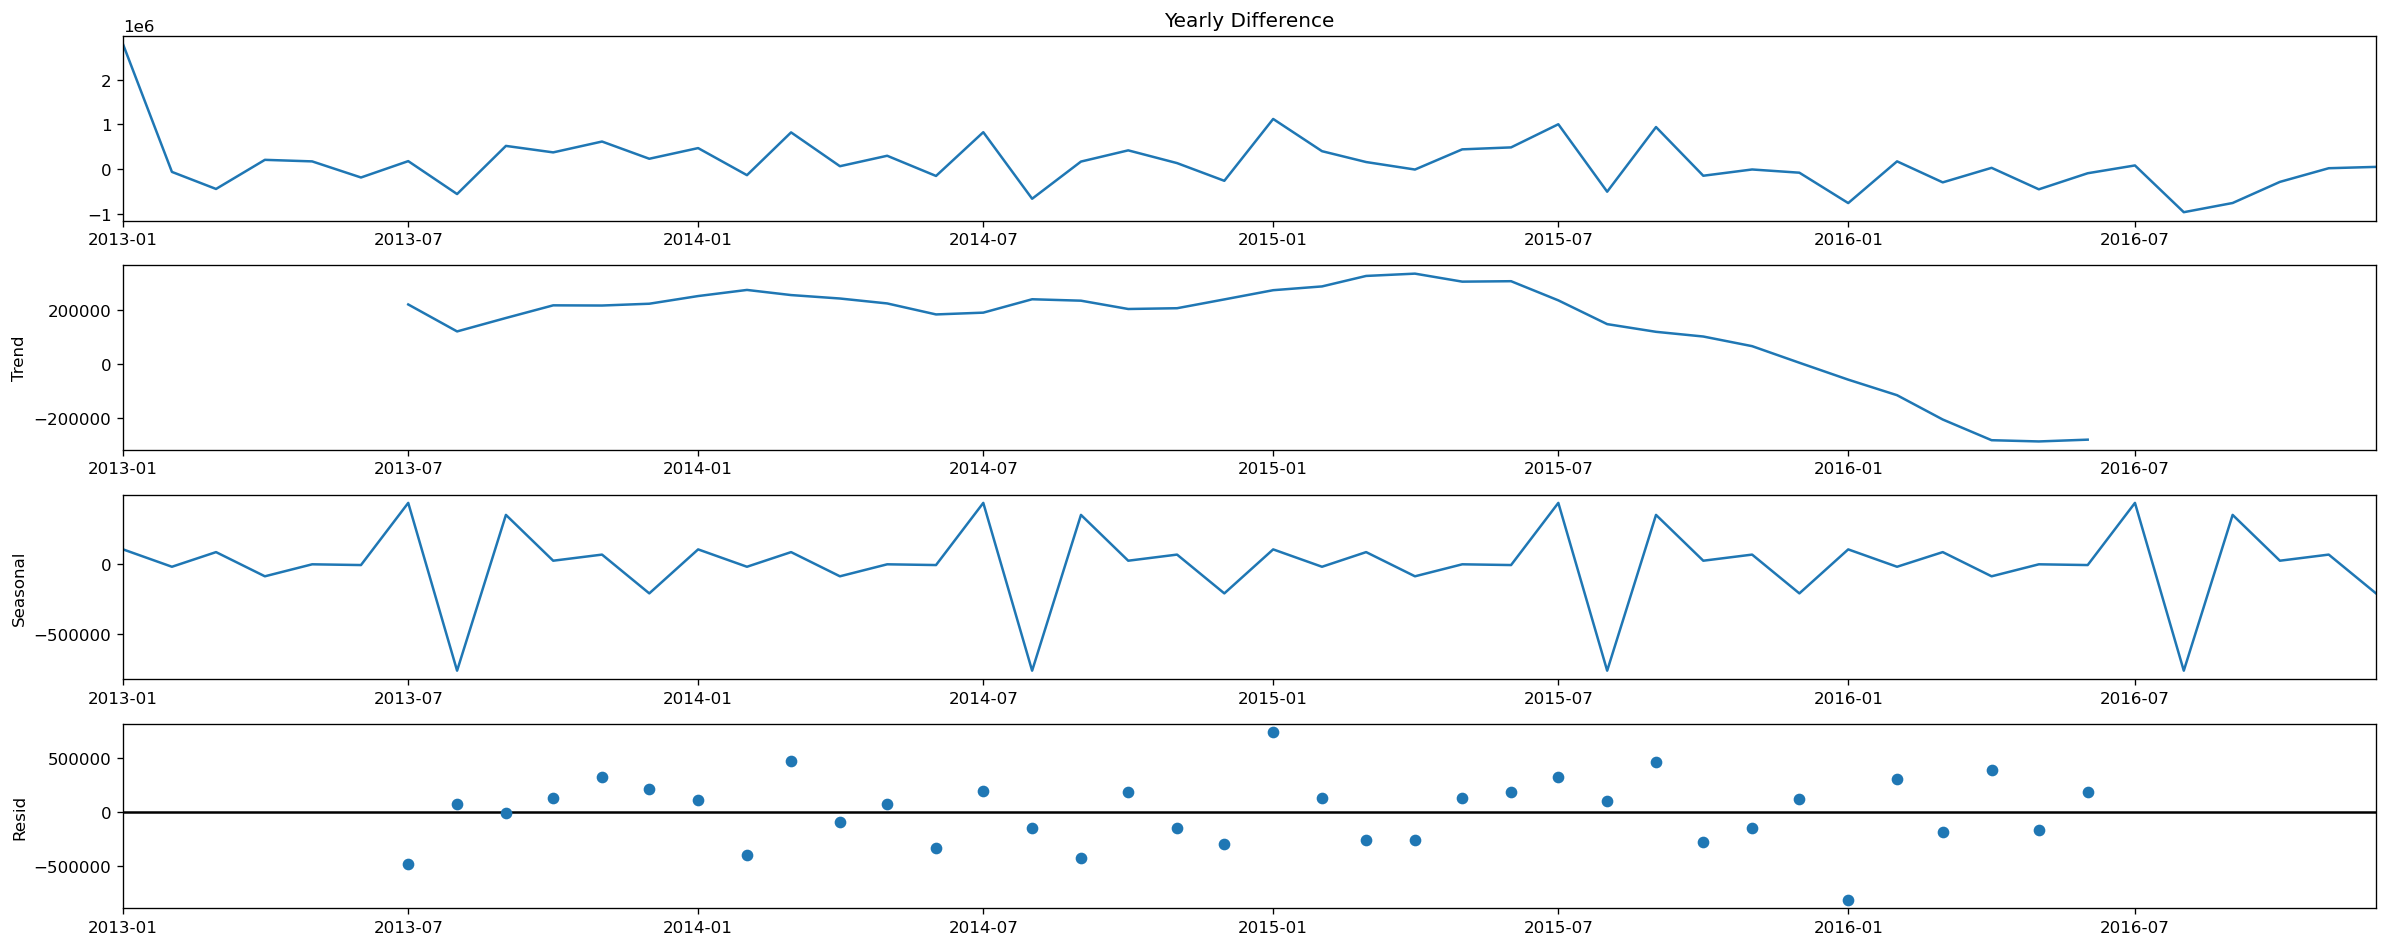

ADF Test Statistic             -4.783210
p-value                         0.000059
Number of Lags Used             1.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64
Reject the Null Hypothesis; Data is stationary.


In [31]:
rcParams['figure.figsize'] = 20, 8
decomposition_2 = sm.tsa.seasonal_decompose(df_shift_yearly, model='additive')
fig = decomposition_2.plot()
plt.show()
stationary_test(df_shift_yearly)

It is similar to monthly shifted data, we got smaller p-value than original data and ADF Test Statistic Value and Critical value is much closer than the monthly shifted data. So I got a stationary data with a greater accuracy.

<b>3. Deseasoned Data

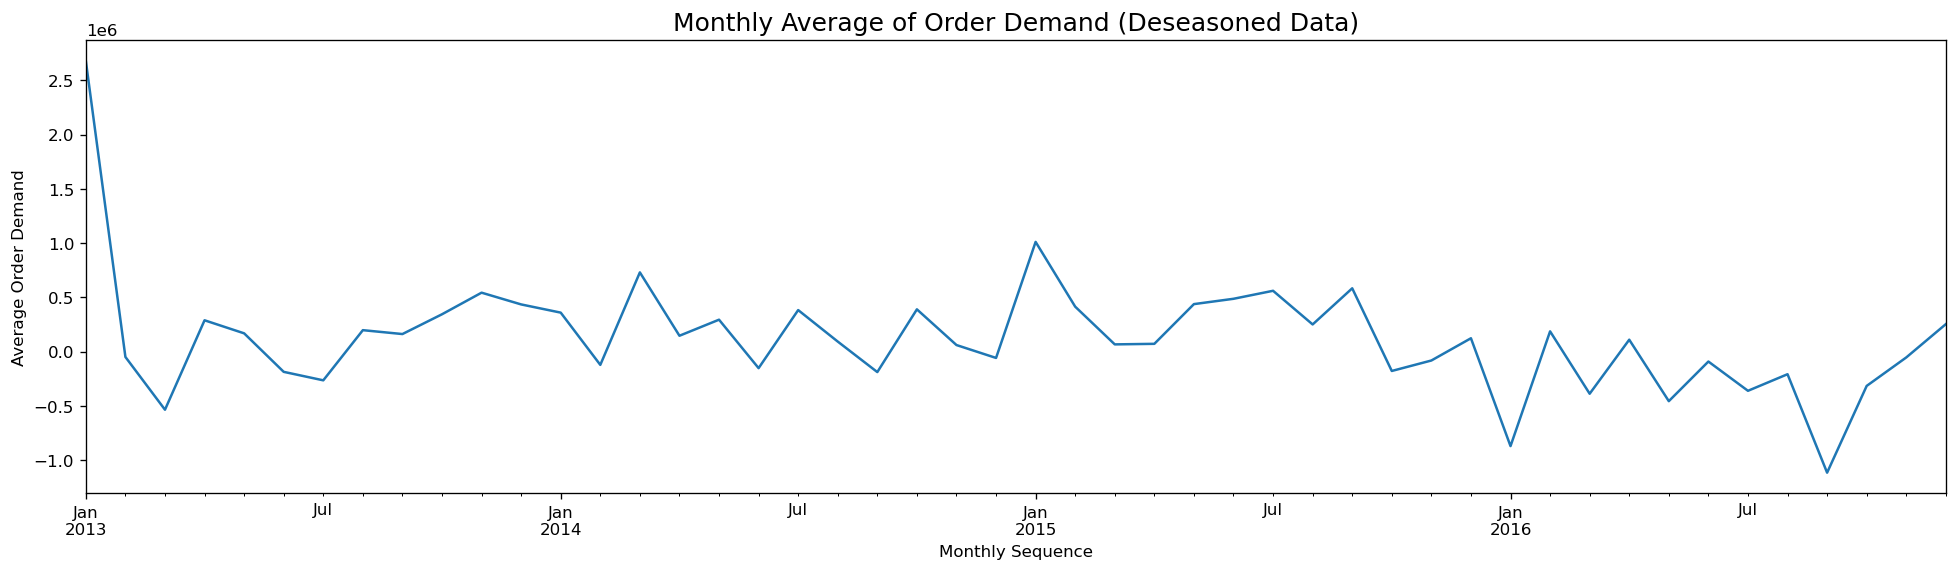

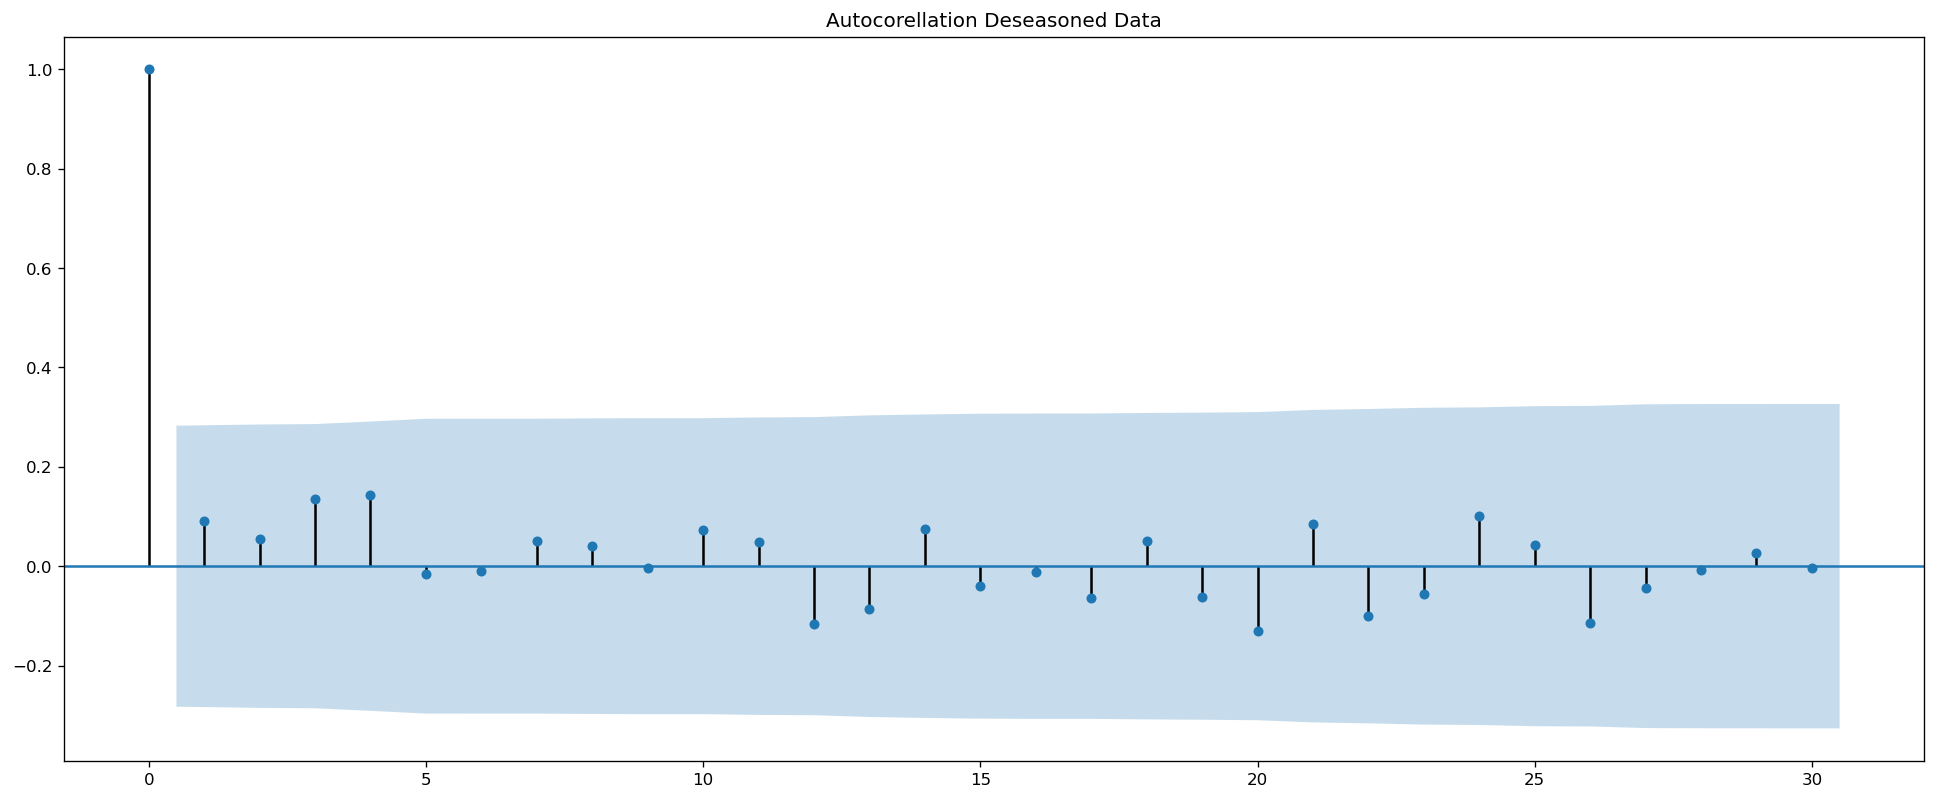

In [32]:
df_des = df_ts['Yearly Difference'].resample('MS').mean() - decomposition_2.seasonal
df_des = df_des.dropna()
df_des.plot(figsize = (20,5))
plt.xlabel('Monthly Sequence')
plt.ylabel('Average Order Demand')
plt.title('Monthly Average of Order Demand (Deseasoned Data)', fontsize = 15)

plot_acf(df_des, lags = 30, title = 'Autocorellation Deseasoned Data')

plt.show()

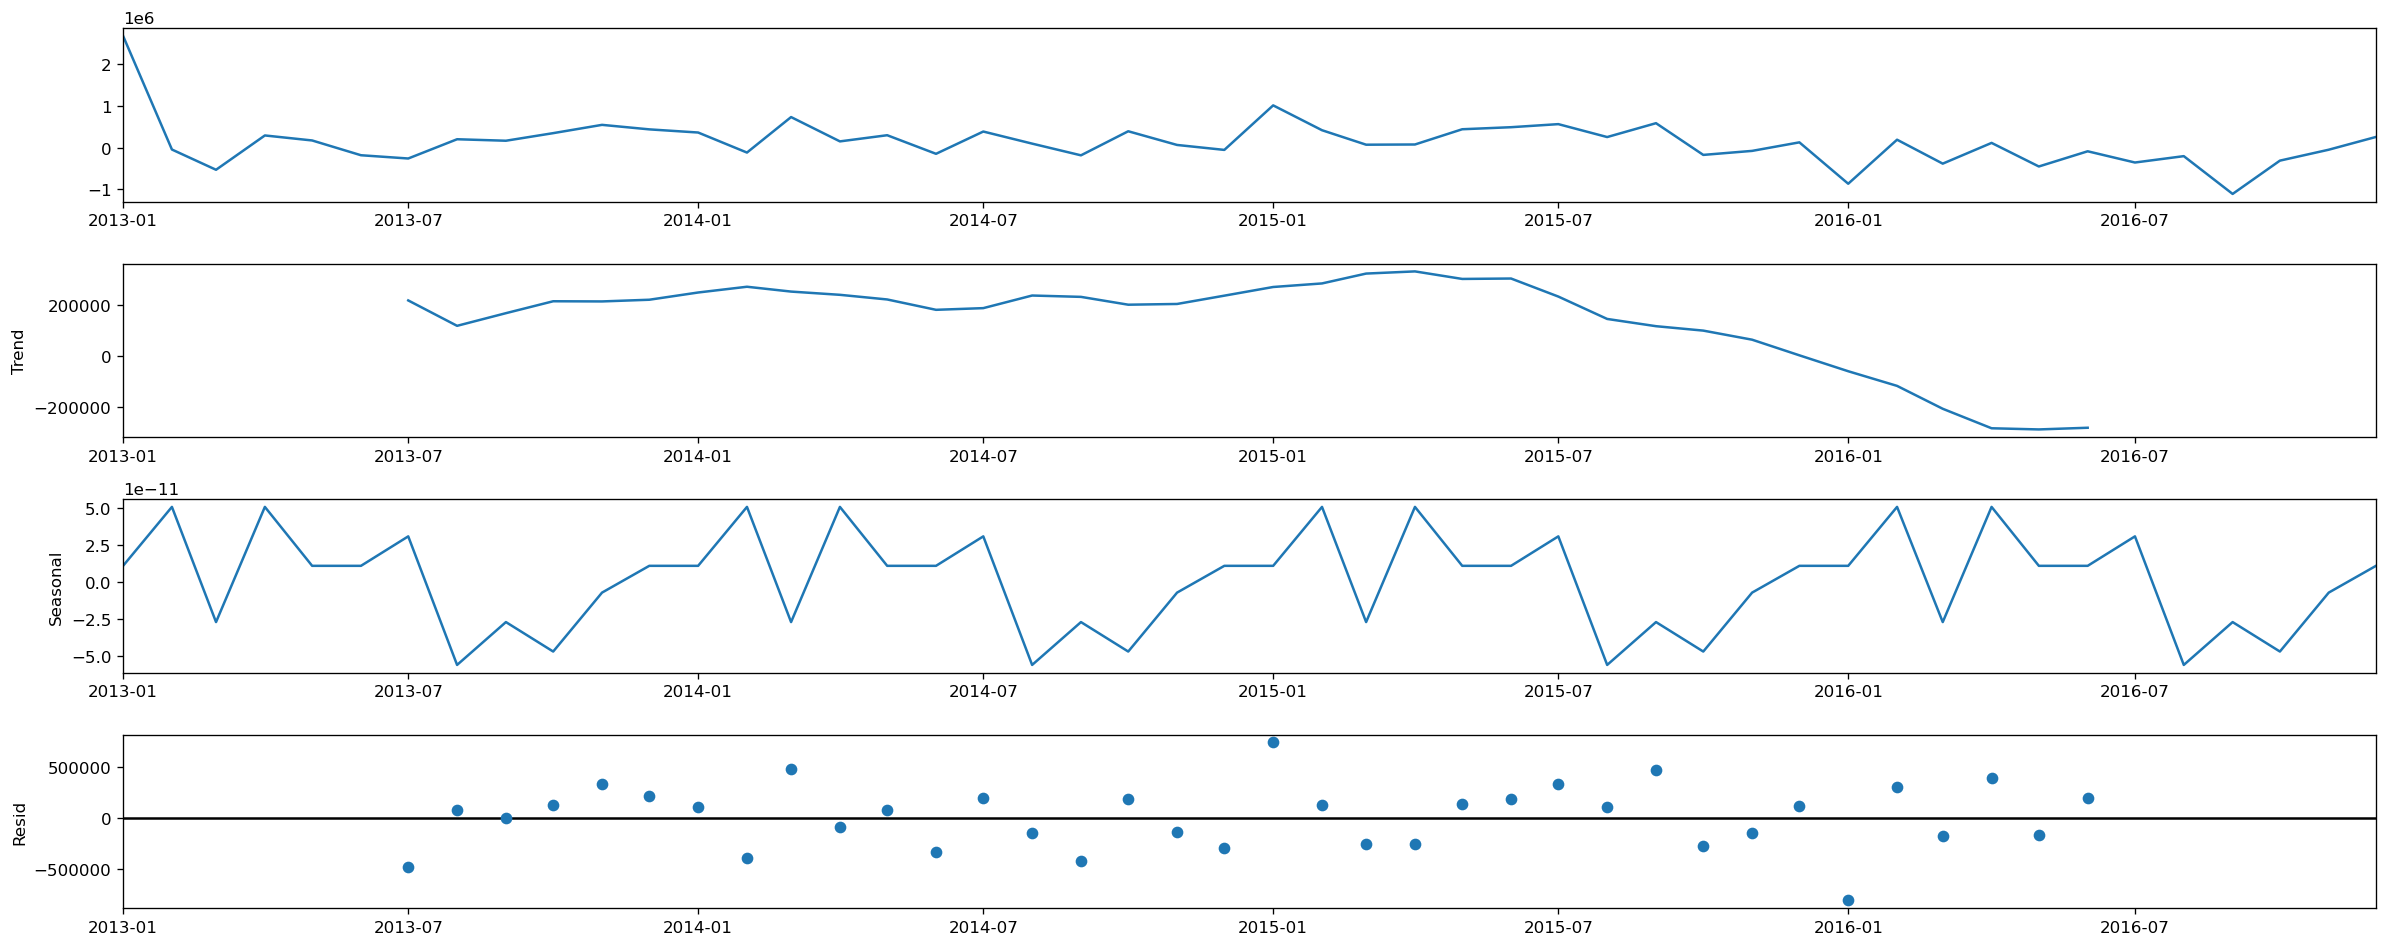

ADF Test Statistic             -4.333421
p-value                         0.000389
Number of Lags Used             1.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64
Reject the Null Hypothesis; Data is stationary.


In [33]:
rcParams['figure.figsize'] = 20, 8
decomposition_3 = sm.tsa.seasonal_decompose(df_des, model='additive')
fig = decomposition_3.plot()
plt.show()
stationary_test(df_des.dropna())

It seems that there is no much difference between Deseasoned Data and Yearly Shifted Data in terms of Statistics Value.

## ARIMA Model

ARIMA (Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA (Moving Average). It has 3 hyperparameters - P (auto regressive lags), d (order of differentiation), Q (moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

We need to take help of ACF (Auto Correlation Function) & PACF (Partial Auto Correlation Function) plots. ACF & PACF graphs are used to find value of P & Q for ARIMA. We need to check, for which value in x-axis, graph line drops to 0 in y-axis for 1st time.<br>
From PACF (at y=0), get P<br>
From ACF (at y=0), get Q

<b> Determining P and Q parameters

C:\Users\Pavilion\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


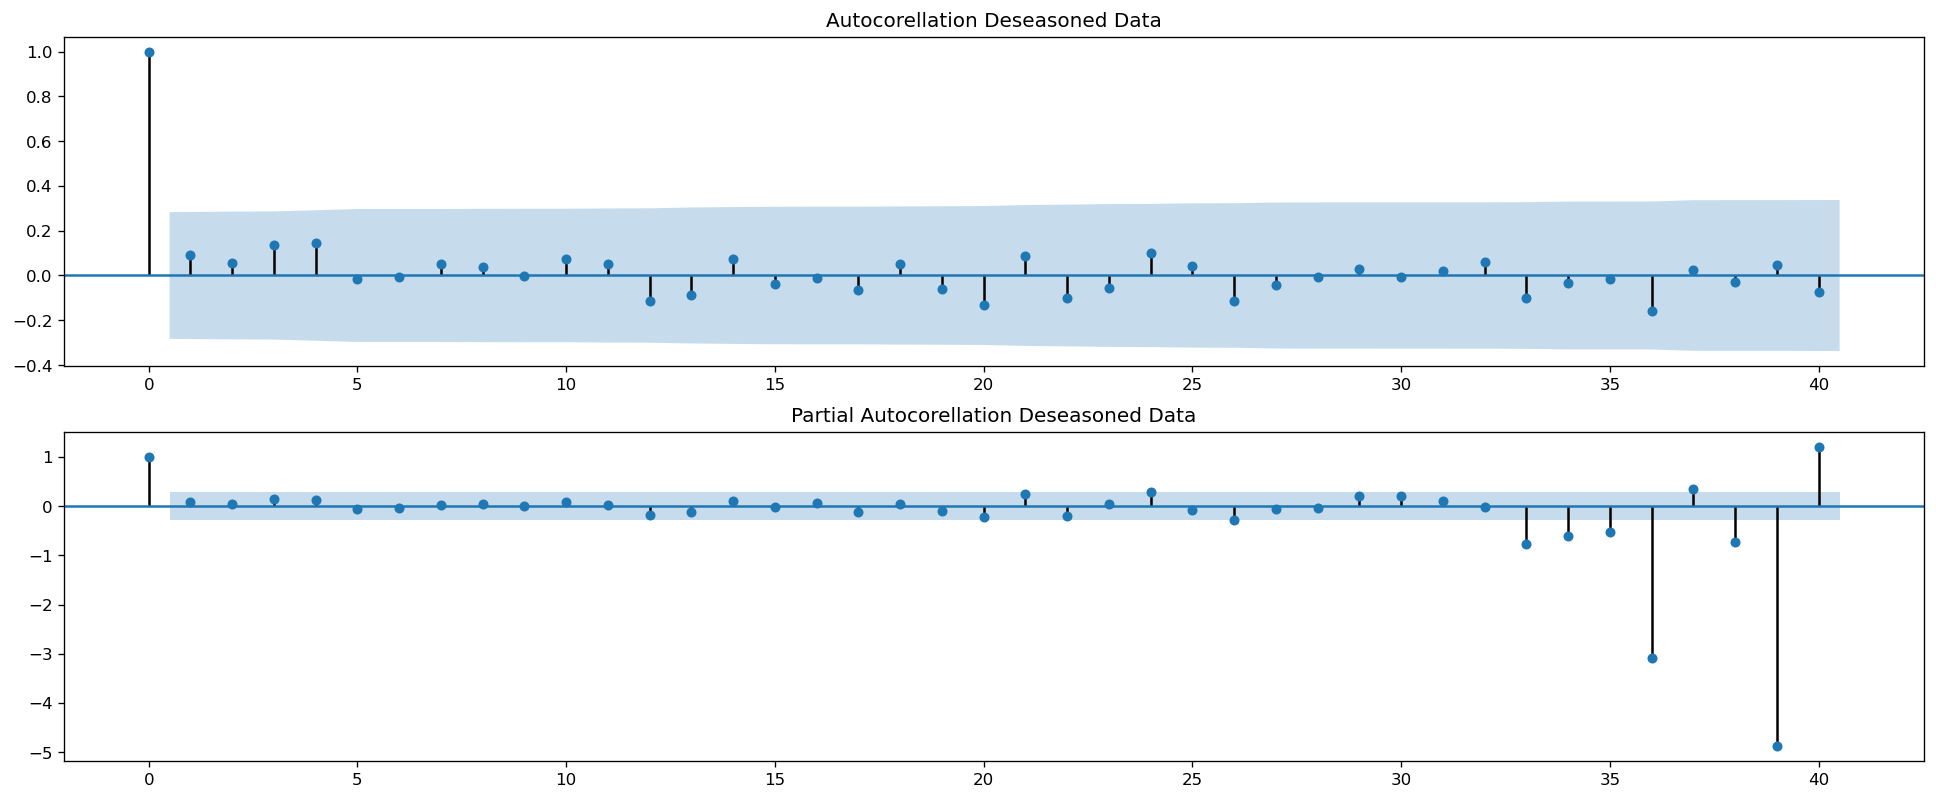

In [34]:
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_des, lags = 40, ax=ax1, title = 'Autocorellation Deseasoned Data')

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_des, lags = 40, ax=ax2, title = 'Partial Autocorellation Deseasoned Data')

To determine <b>p</b> and <b>q</b>, we have to take a look at the first lag that cross the significant line (Blue Area) from both ACF and PACF plot. It seems that in PACF plot, the first lag that cross the significant line in around 33, and for ACF plot, there is no lag that cross the significant area. So I assume that <b>p</b> and <b>q</b> is equal to 0. For <b>d</b> value, we conduct a first-order differencing adressing linear trends, so <b>d</b> value is equal to 1.

<b> ARIMA Model (Auto-ARIMA)

In [35]:
train_arima = df_des[:36]
test_arima = df_des[36:]

model_arima = pm.auto_arima(train_arima, start_p = 0, start_q = 0,
                      test = 'adf',       
                      max_p = 3, max_q = 3, 
                      m = 1,              
                      d = None,           
                      seasonal = False,   
                      start_P = 0, 
                      D = 0, 
                      trace = True,
                      error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)

model_arima.summary()

Fit ARIMA: order=(0, 1, 0); AIC=1037.454, BIC=1040.565, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1038.277, BIC=1042.943, Fit time=0.012 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1029.765, BIC=1034.431, Fit time=0.139 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 2); AIC=1031.748, BIC=1037.969, Fit time=0.137 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.311 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   35
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -511.883
Method:                       css-mle   S.D. of innovations         516669.082
Date:                Fri, 03 Jul 2020   AIC                           1029.765
Time:                        00:52:48   BIC                           1034.431
Sample:                             1   HQIC                          1031.376
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4586.2881   8288.686     -0.553      0.580   -2.08e+04    1.17e+04
ma.L1.D.y     -0.9999      0.083    -11.976      0.000      -1.163      -0.836
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

From Auto-ARIMA model above, it seems that the optimal value for (p, d, q) is (0, 1, 1) for the lowest AIC and BIC.

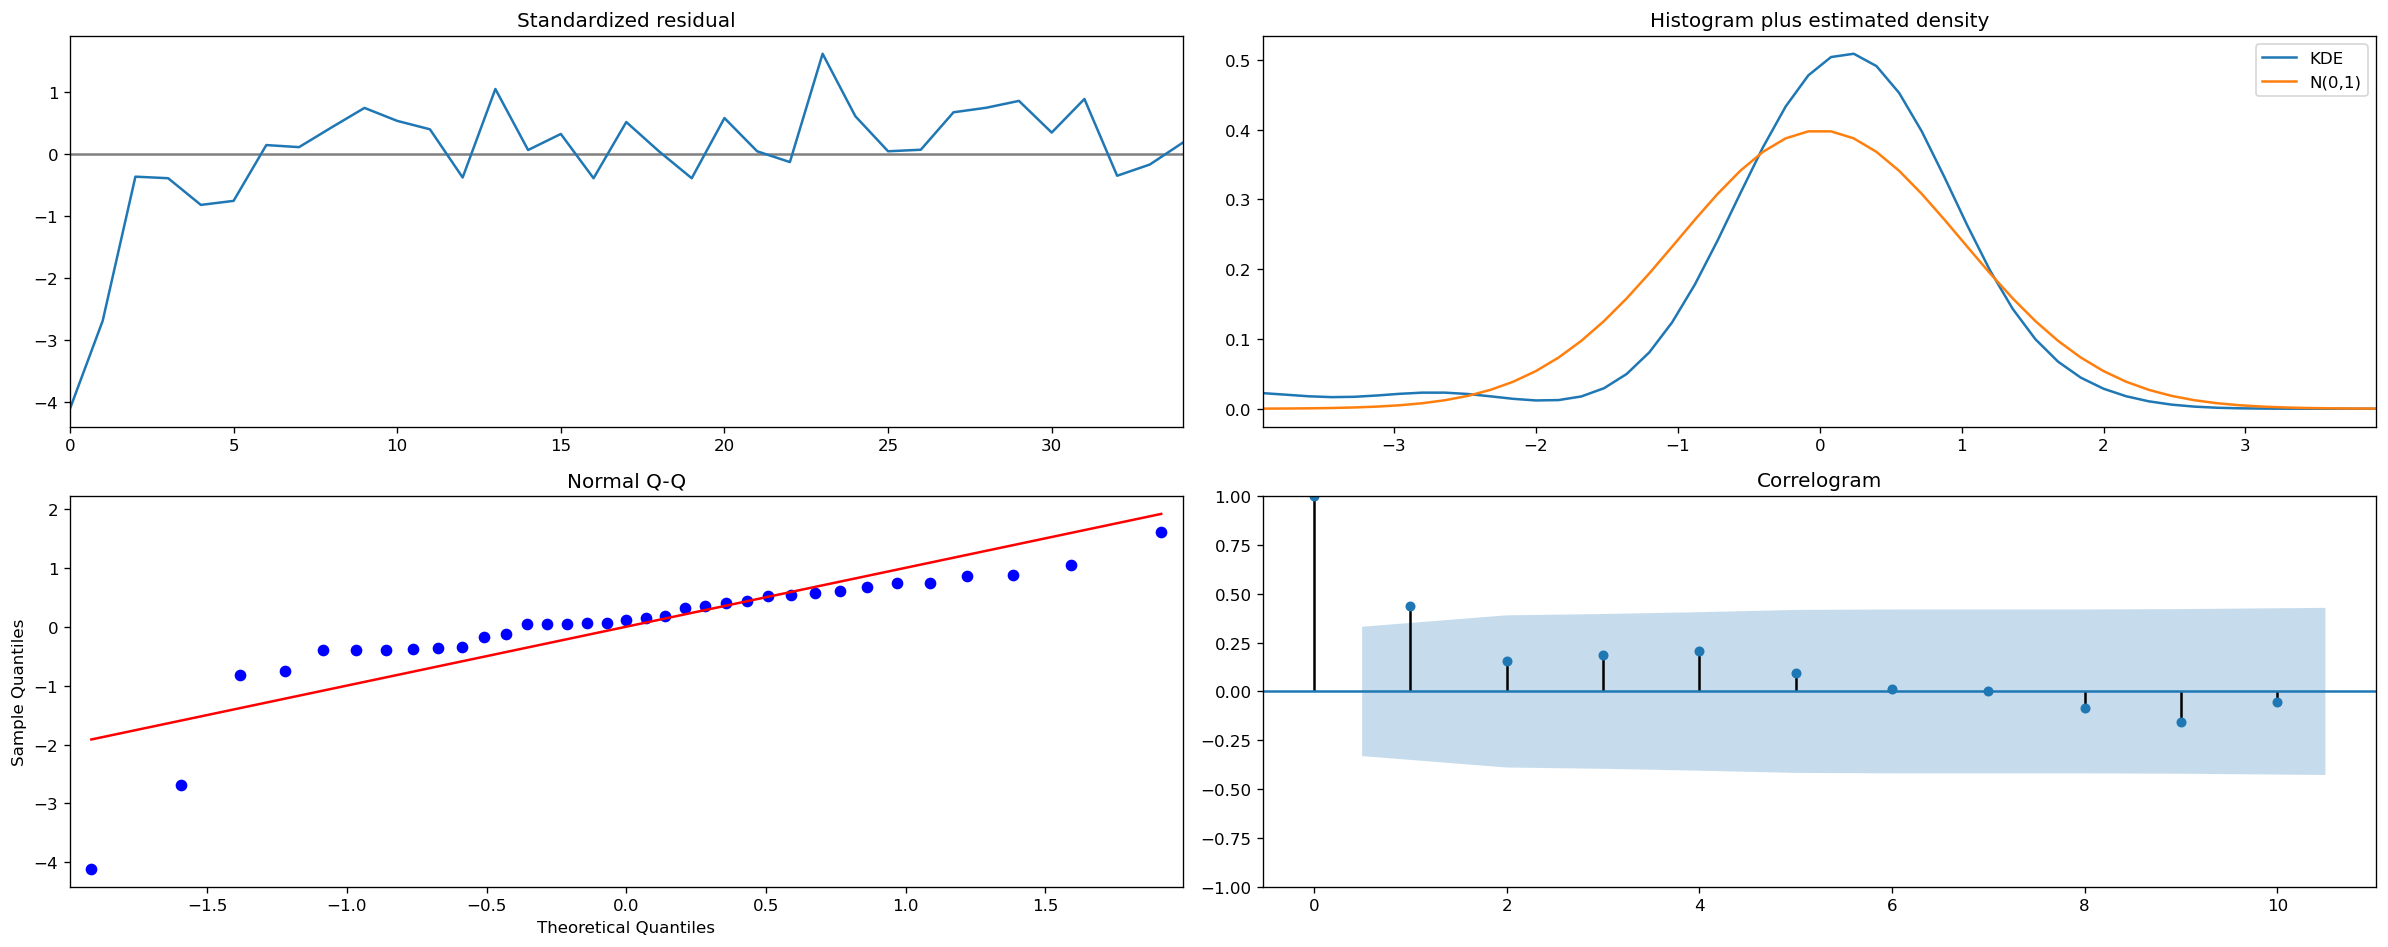

In [36]:
model_arima.plot_diagnostics(figsize=(20,8))
plt.tight_layout()
plt.show()

From diagnostic plot above, it seems that residual is normally distributed. The qq plot on the bottom left shows that the blue dots following the red line, though it is not perfectly aligned. Also, on the top right plot, the KDE plot follows the orange line and form a normal distribution.

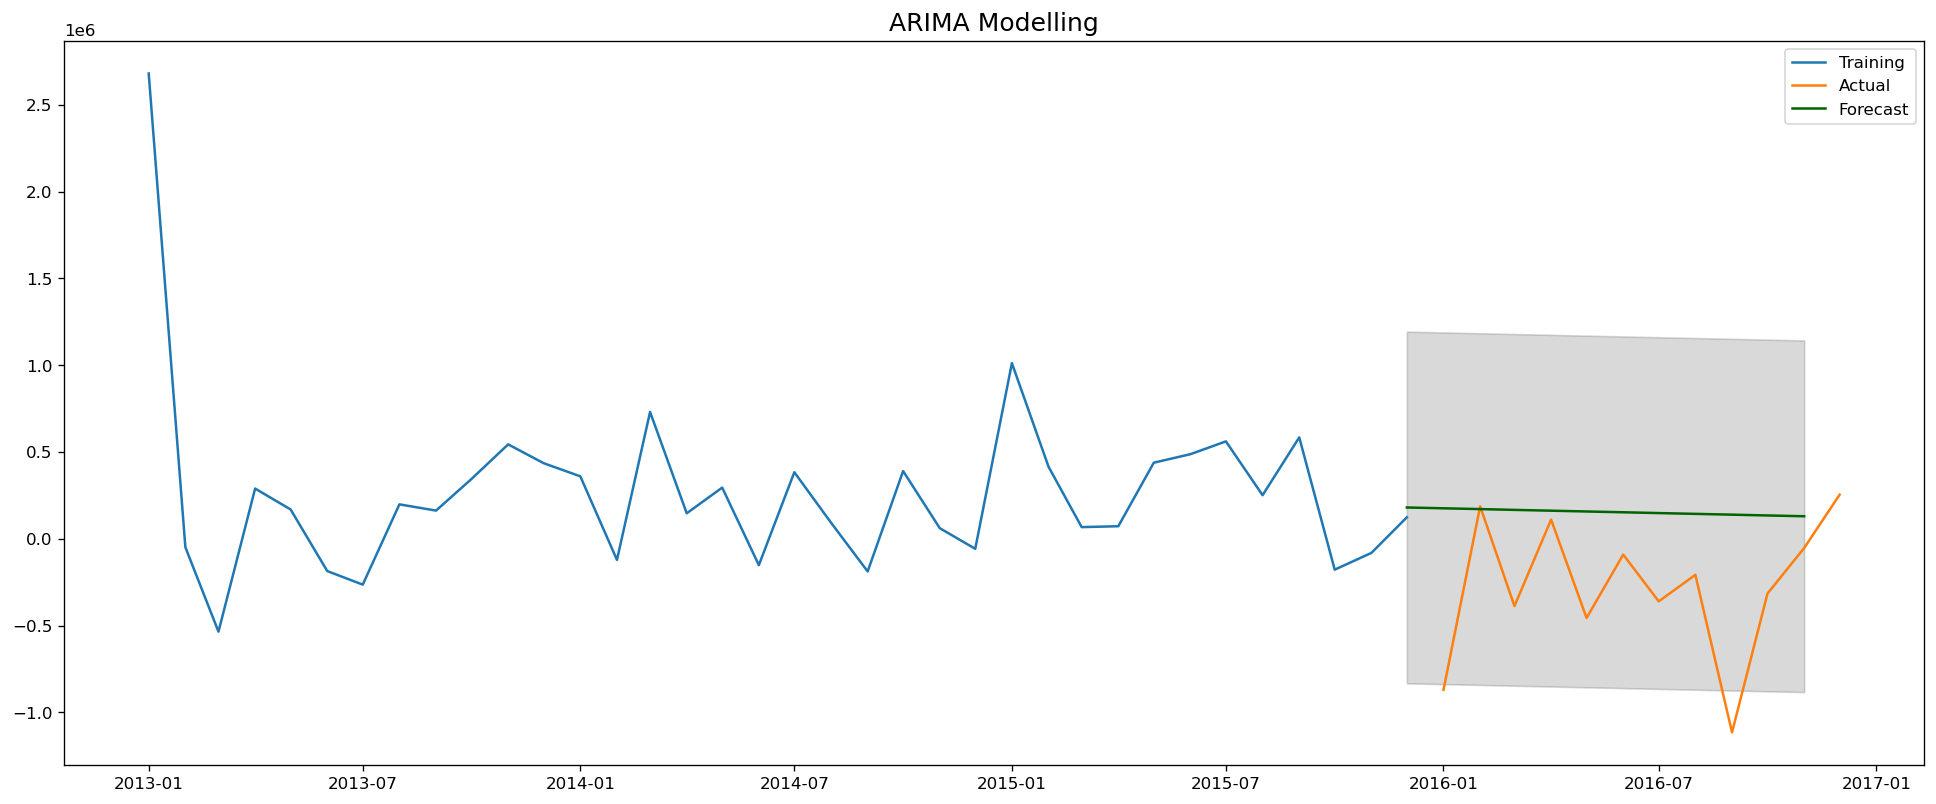

In [37]:
fitted, confint = model_arima.predict(n_periods=12, return_conf_int=True) 
index_of_fc = pd.date_range(train_arima.index[-1], periods = 12, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.figure(figsize = (20,8))
plt.plot(train_arima, label ='Training')
plt.plot(test_arima, label = 'Actual')
plt.plot(fitted_series, color='darkgreen', label ='Forecast')
plt.legend()
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title('ARIMA Modelling', fontsize = 15)
plt.show()

Because we split our data into train and test, we find that our plot is not continous.

Also, the ARIMA model just give us a straight line forecasting. Let's check Mean Absolute Percentage Error (MAPE).

In [38]:
mape_arima = np.mean(np.abs(fitted - test_arima)/np.abs(test_arima))
mape_arima

1.4215553602235473

MAPE value shows a very small error value, it means we have almost 99% accuracy. So it is wise to use 2 validation method, by plotting and see its MAPE value.

Let's use SARIMA Model.

## SARIMA Model

In [39]:
train_sarima = df_ori[:48]
test_sarima = df_ori[48:]

model_sarima = pm.auto_arima(train_sarima, 
                            start_p = 0, start_q = 0,
                            test = 'adf',
                            max_p = 3, max_q = 3, m = 12,
                            start_P = 0, seasonal = True,
                            d = None, D = 1, trace = True,
                            error_action = 'ignore',  
                            suppress_warnings = True, 
                            stepwise = True)

model_sarima.summary()

Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=1007.661, BIC=1012.240, Fit time=0.079 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1013.490, BIC=1016.543, Fit time=0.010 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=1003.085, BIC=1009.190, Fit time=0.092 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=983.361, BIC=989.466, Fit time=0.123 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 1, 1, 12); AIC=985.314, BIC=992.946, Fit time=0.250 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=981.395, BIC=985.974, Fit time=0.088 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 12); AIC=976.673, BIC=982.778, Fit time=0.123 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=1008.419, BIC=1012.998, Fit time=0.030 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 1, 0, 12); AIC=995.070, BIC=1002.702, Fit time=0.090 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_o

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(1, 2, 1)x(0, 1, [], 12)   Log Likelihood                -484.336
Date:                             Fri, 03 Jul 2020   AIC                            976.673
Time:                                     00:52:51   BIC                            982.778
Sample:                                          0   HQIC                           978.755
                                              - 48                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -614.2692   4162.837     -0.148      0.883   -8773.280    7544.741
ar.L1         -0.3997      0.187     -2.137      0.033      -0.766      -0.033
ma.L1         -1.0000      0.291     -3.431      0.001      -1.571      -0.429
sigma2       1.45e+11   8.06e-10    1.8e+20      0.000    1.45e+11    1.45e+11
===================================================================================
Ljung-Box (Q):                       65.52   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.00   Prob(JB):                         0.91
Heteroskedasticity (H):               0.88   Skew:                            -0.10
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.83e+41. Standard errors may be unstable.
"""

From Auto-ARIMA simulation, we get the best parameter for SARIMA model, SARIMA(1, 2, 1)x(0, 1, 0, 12).

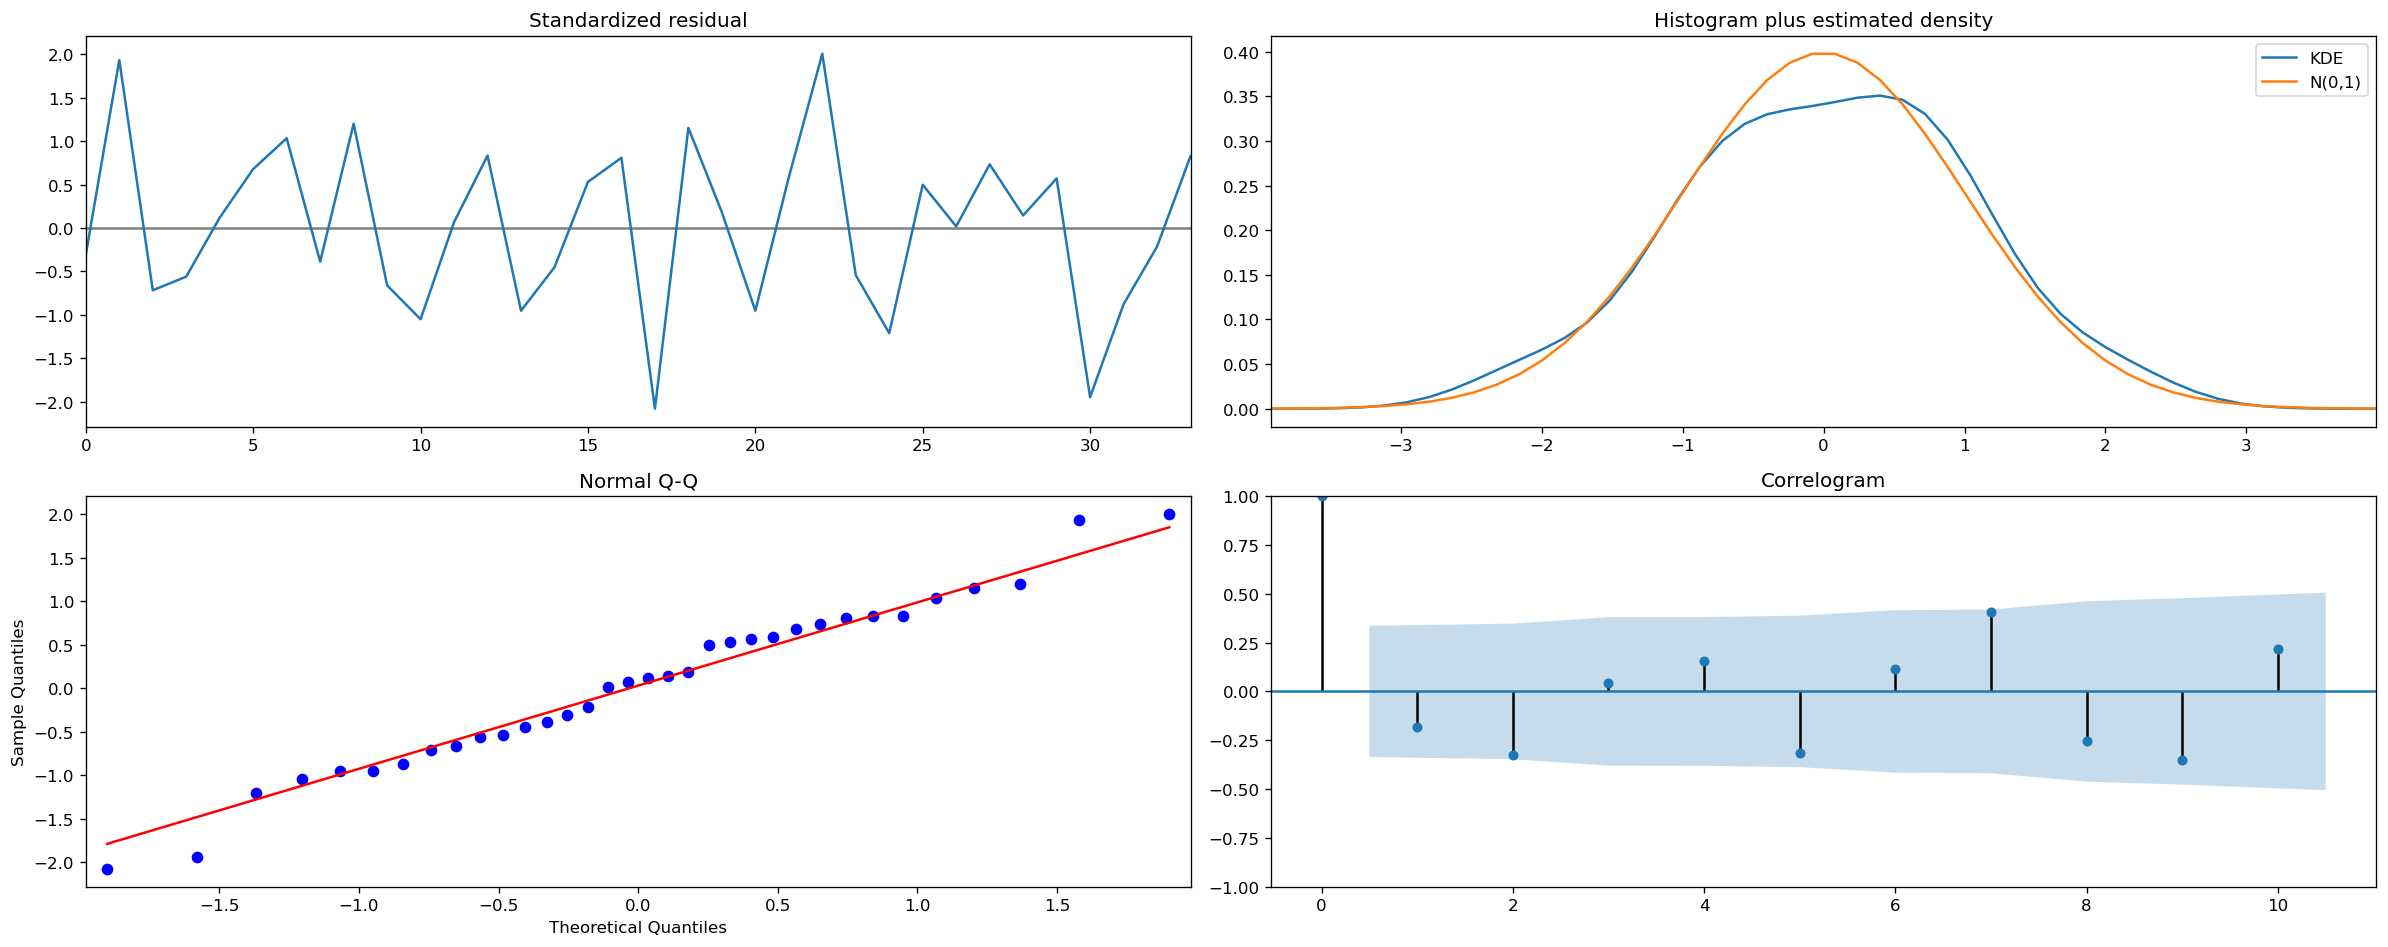

In [40]:
model_sarima.plot_diagnostics(figsize=(20,8))
plt.tight_layout()
plt.show()

With SARIMA model, we have a better qq-plot and KDE-N distribution. Both shows that, residual is normally distributed. <br>
Also, residuals are not correlated. It is shown from top-left plot that shows a white noise-y characteristic and from bottom right correlogram, we can see a pattern.

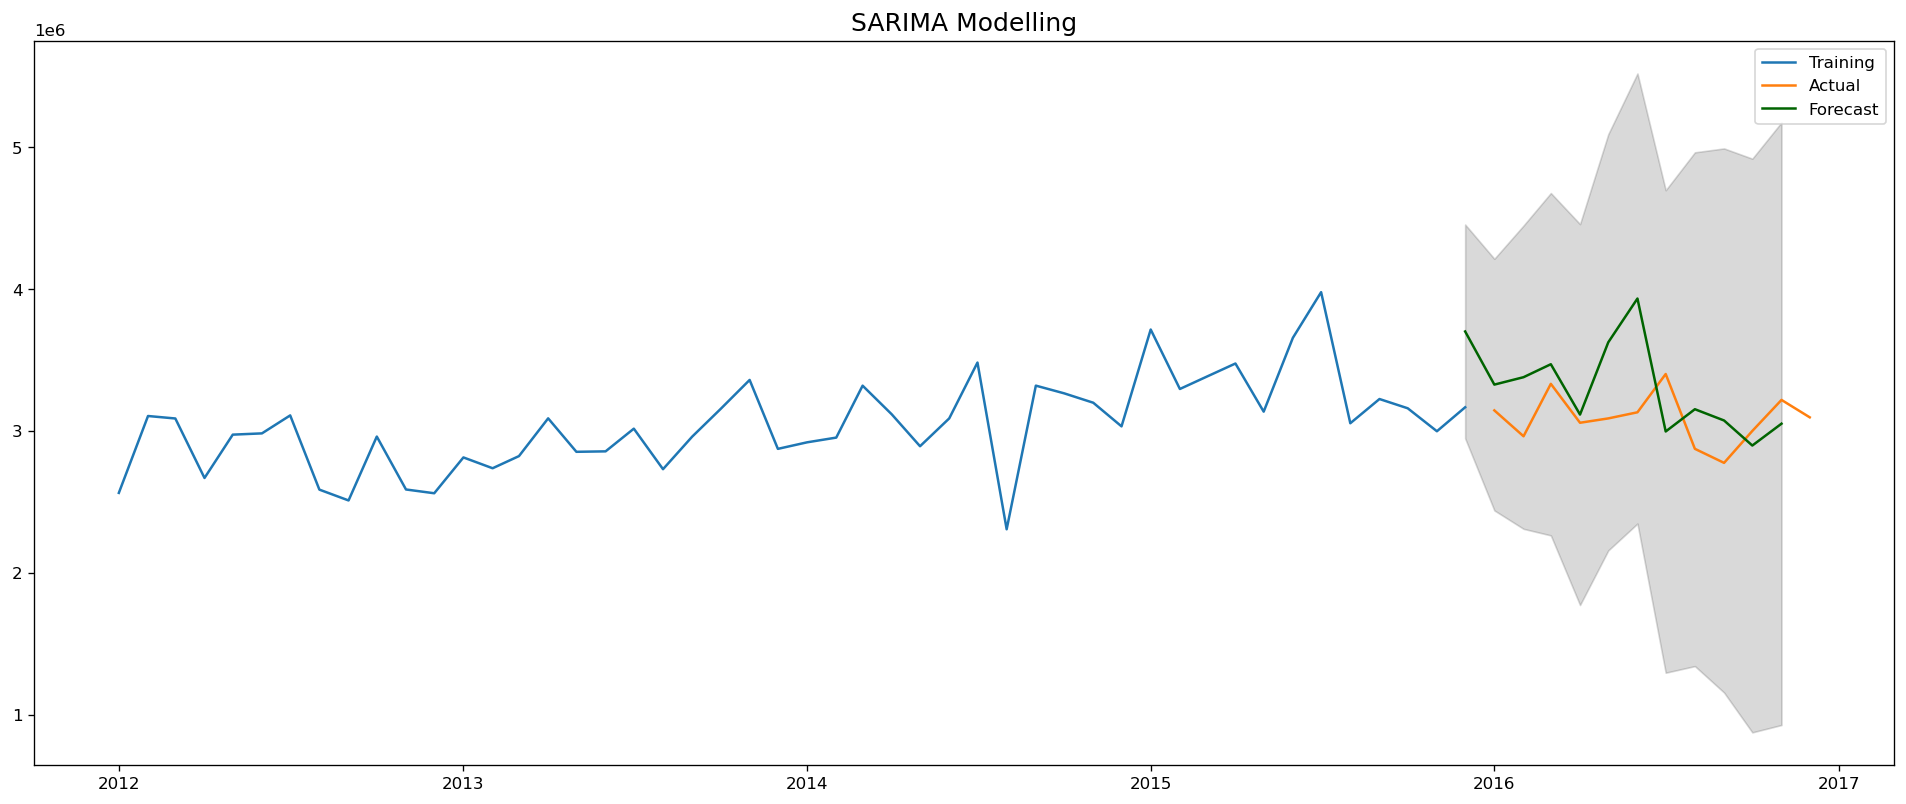

In [41]:
fitted, confint = model_sarima.predict(n_periods=12, return_conf_int=True) 
index_of_fc = pd.date_range(train_sarima.index[-1], periods = 12, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.figure(figsize = (20,8))
plt.plot(train_sarima, label ='Training')
plt.plot(test_sarima, label = 'Actual')
plt.plot(fitted_series, color='darkgreen', label ='Forecast')
plt.legend()
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title('SARIMA Modelling', fontsize = 15)
plt.show()

From forecasting above, it seems that the forecasted value follows the trend but not correctly forecasted it.

In [42]:
mape_sarima = np.mean(np.abs(fitted - test_sarima)/np.abs(test_sarima))
mape_sarima

0.09080994454428203

From MAPE value and plotting, it seems that SARIMA model is better.

# Forecasting

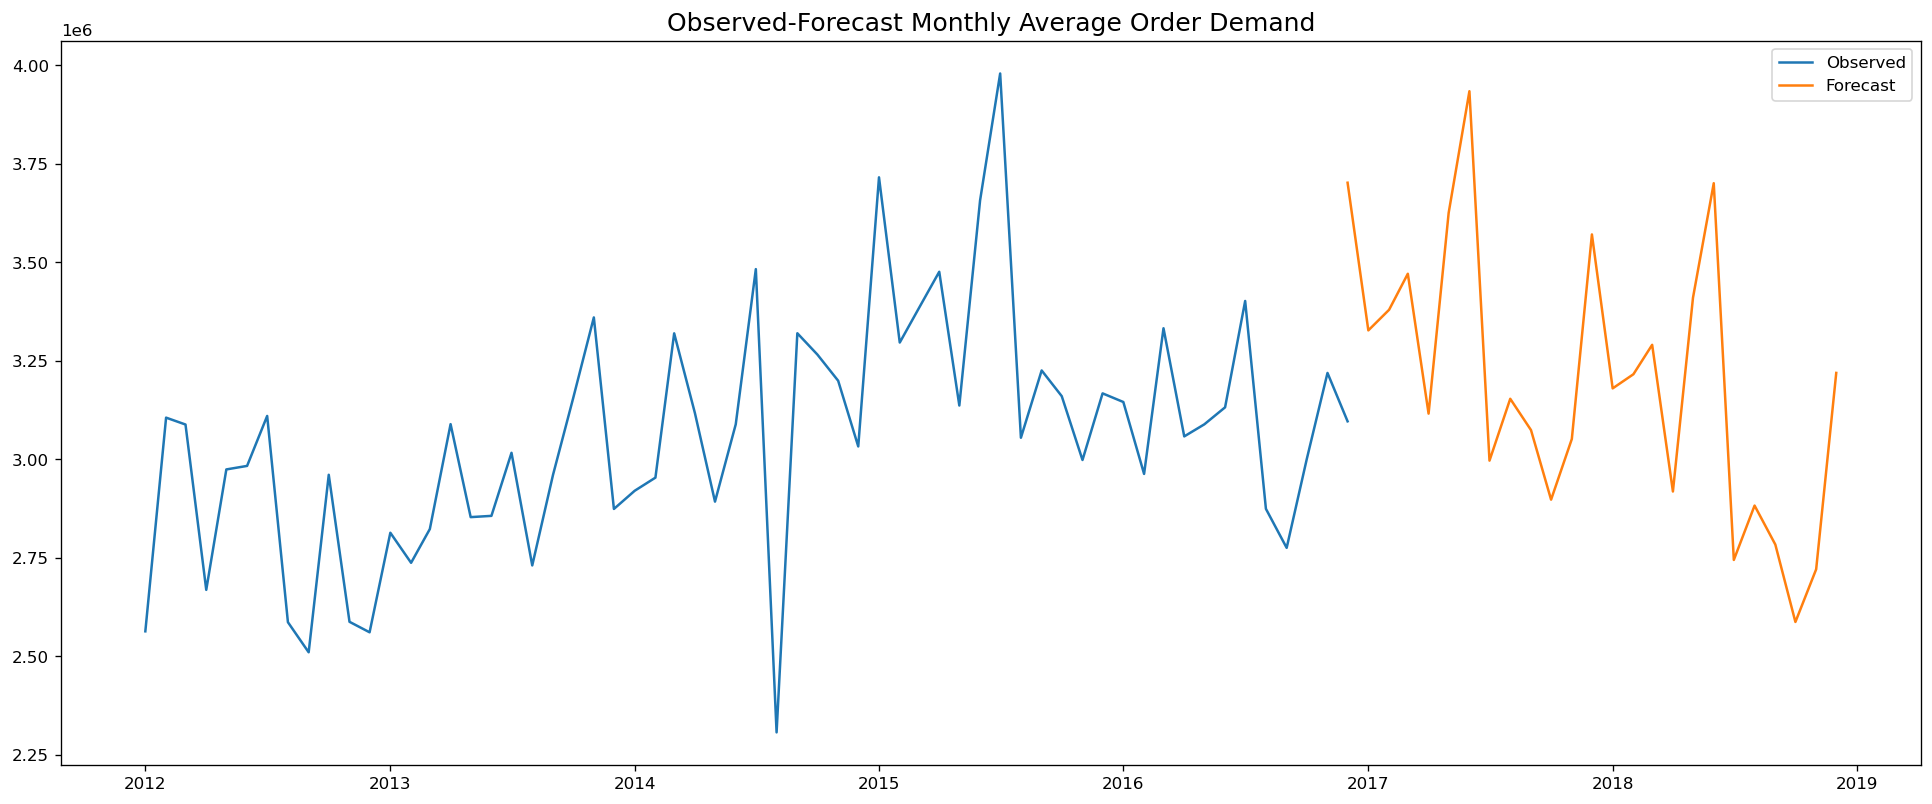

In [43]:
model_sarima.fit(train_sarima)

forecasting_dates = [df_ori.index[-1] + DateOffset(months = x)for x in range(0,25)]
forecast = model_sarima.predict(n_periods = 25)

df_forecast = pd.DataFrame({'Forecast Demand' : forecast}, index = forecasting_dates)

plt.figure(figsize = (20,8))
plt.plot(df_ori, label = 'Observed')
plt.plot(df_forecast, label = 'Forecast')
plt.title('Observed-Forecast Monthly Average Order Demand', fontsize = 15)
plt.legend()
plt.show()

# Conclusion

1. We have sucessfully built 2 models for forecasting product order demand by using ARIMA and SARIMA model.
2. SARIMA model is the better model with better residual behaviors and Accuracy around 99%.
3. For future demand, Company has to strategize something to make their product's demand increase, either better marketing strategy or launch a new product.